# Setup
Run these cells to import packages and set up important variables.

<mark>**Important note RE timing:**</mark><br>
Run 1 scan time is shorter than expected. This was observed here and on the preproc data right out of flywheel: Most likely this is an error coming from the scanning parameters. Will need to check this and update the params with BRIDGE.<br>Scan time should be have been 599 seconds (299.5=300Trs). Right now it is 592 seconds (296 TRs). **There are 2 TRs missing from run 1.**

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, glob, itertools
from os.path import join
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import omegaconf
import hydra
import torch
import torchvision.transforms as T
from r3m import load_r3m

from nilearn import image
from nilearn.masking import apply_mask, unmask
from nilearn.image import index_img, resample_to_img
from nilearn.plotting import plot_anat, view_img, plot_img, plot_glass_brain

from scipy.stats import pearsonr, zscore, spearmanr
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
import nibabel as nib

from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, AutoModel, AutoModelForCausalLM
from torchvision.models import resnet50
# print(resnet(preprocessed_image).shape)
from PIL import Image
import torch
from collections import defaultdict
from text_embedding_utils import get_single_string_embedding, get_multi_string_embedding

import sys, os
import pickle
import shutil

sys.path.append(os.path.abspath('./speechmodeltutorial'))
from interpdata import lanczosfun, lanczosinterp2D
from util import make_delayed
from ridge import bootstrap_ridge

# Configure matplotlib
plt.style.use('config/plotconfig.mplstyle')

C:\Users\noush\miniconda3\envs\xaqlab2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = 'data'
figure_dir = 'figures'
fmri_dir  = join(data_dir,'niftis')
frames_dir = join('stimuli','runs_4hz_frames')
annotations_dir = '/Users/julien/Library/CloudStorage/Dropbox/Work/Projects/Ongoing/natcook/annotation/model_annotations/out_annot'

run_name_template = "pilot2_natcook_run{}+tlrc.nii.gz"

all_run_numbers = [1, 2, 3, 4, 5, 6]
train_run_numbers = [1,2,4,5]
test_run_numbers = [3,6]
FPS = 4 # framerate of stimuli
SEED = 42
TR = 2

# Load fMRI Data

In [5]:
brainmask_path = join(fmri_dir, 'pilot2_natcook_brainmask+tlrc.nii.gz')
brainmask_img = image.load_img(brainmask_path)

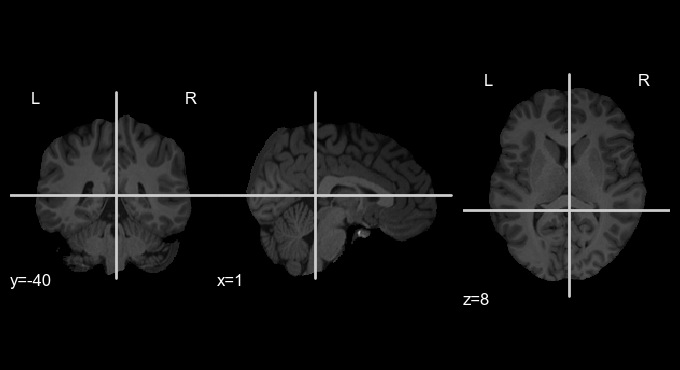

In [6]:
plot_anat(join(fmri_dir, 'pilot2_anat_final+tlrc.nii.gz'))

## Whole-brain

In [8]:
ROI = 'whole'
runs_fmri = {}
runs_img = {}
for run_number in tqdm(all_run_numbers):

    # get the run path
    run_path = join(fmri_dir, run_name_template.format(run_number))

    # read the run img
    run_img = image.load_img(run_path)

    # mask out non brain voxels
    masked_data = apply_mask(run_img, brainmask_img)

    # # Reconstruct the 4D volumetric masked data
    masked_img = unmask(masked_data, brainmask_img)

    runs_fmri[run_number] = masked_data
    runs_img[run_number] = masked_img

100%|██████████| 6/6 [01:14<00:00, 12.35s/it]


Generate a gif of the brain data over time for a specific run

In [13]:
def brain_gif_maker(run_img, run_fmri, filename, skip_frames = 1, output_dir = None, temp_dir = None):
    # Read the run img
    imgs = image.iter_img(run_img)
    filenames = []

    # Create directories
    if temp_dir is None:
        temp_dir = 'gif_frames'
    if output_dir is None:
        output_dir = join(figure_dir, 'gifs')
    os.makedirs(temp_dir, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)

    # Plot with diverging colormap centered on mean across time
    mean_val = np.mean(run_fmri)
    vmax_abs = max(abs(np.max(run_fmri) - mean_val), abs(mean_val - np.min(run_fmri)))
    vmin = mean_val - vmax_abs
    vmax = mean_val + vmax_abs

    # Generate frame for each time point
    for i, img in tqdm(enumerate(imgs)):

        if i % skip_frames != 0:
            continue

        # Save each frame to a file
        fn = os.path.join(temp_dir, f"frame_{i:03d}.png")
        display = plot_glass_brain(
            img,
            cmap='seismic',
            vmin=vmin,
            vmax=vmax,
            plot_abs=False
        )
        display.savefig(fn)
        display.close()
        filenames.append(fn)

    # Load frames and save as GIF
    frames = []
    for fn in filenames:
        with Image.open(fn) as img:
            frames.append(img.copy())
    frames[0].save(join(output_dir, filename), format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=200,  # ms per frame
                   loop=0)
    shutil.rmtree(temp_dir)

run_number = 1
brain_gif_maker(runs_img[run_number], runs_fmri[run_number], f'run{run_number}_functional.gif', skip_frames=20)

296it [00:19, 14.97it/s]


## By brain region

In [14]:
# Get an atlas
atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")

# The first label correspond to the background
print(f"The atlas contains {len(atlas.labels) - 1} non-overlapping regions")

# Instantiate the masker with label image and label values
masker = NiftiLabelsMasker(
    atlas.maps,
    labels=atlas.labels,
    standardize="zscore_sample",
)

# Visualize the atlas
# Note that we need to call fit prior to generating the mask
masker.fit()

# At this point, no functional image has been provided to the masker.
# We can still generate a report which can be displayed in a Jupyter
# Notebook, opened in a browser using the .open_in_browser() method,
# or saved to a file using the .save_as_html(output_filepath) method.
report = masker.generate_report()
report

[get_dataset_dir] Dataset found in C:\Users\noush\nilearn_data\fsl
The atlas contains 48 non-overlapping regions


C:\Users\noush\AppData\Local\Temp\ipykernel_34912\350710353.py:22: UserWarning: No image provided to fit in NiftiLabelsMasker. Plotting ROIs of label image on the MNI152Template for reporting.
  report = masker.generate_report()


In [13]:
atlas.labels

['Background',
 'Frontal Pole',
 'Insular Cortex',
 'Superior Frontal Gyrus',
 'Middle Frontal Gyrus',
 'Inferior Frontal Gyrus, pars triangularis',
 'Inferior Frontal Gyrus, pars opercularis',
 'Precentral Gyrus',
 'Temporal Pole',
 'Superior Temporal Gyrus, anterior division',
 'Superior Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, anterior division',
 'Middle Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, temporooccipital part',
 'Inferior Temporal Gyrus, anterior division',
 'Inferior Temporal Gyrus, posterior division',
 'Inferior Temporal Gyrus, temporooccipital part',
 'Postcentral Gyrus',
 'Superior Parietal Lobule',
 'Supramarginal Gyrus, anterior division',
 'Supramarginal Gyrus, posterior division',
 'Angular Gyrus',
 'Lateral Occipital Cortex, superior division',
 'Lateral Occipital Cortex, inferior division',
 'Intracalcarine Cortex',
 'Frontal Medial Cortex',
 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
 'Subcallo

In [159]:
rois = ['Frontal Pole', 'Superior Parietal Lobule', 'Superior Temporal Gyrus, anterior division', 'Lateral Occipital Cortex, superior division', 'Precentral Gyrus', 'Insular Cortex'] # higher-level object-action representation, language representation, object representation, motor planning representation, control
ROI = rois[5]

runs_fmri = {}
runs_img = {}
for run_number in tqdm(all_run_numbers):
    # Fit masker
    run_path = join(fmri_dir, run_name_template.format(run_number))

    # read the run img
    run_img = image.load_img(run_path)

    # Get atlas labels
    resampled_atlas_img = resample_to_img(atlas.maps, run_img, interpolation='nearest', force_resample=True, copy_header=True)
    atlas_data = resampled_atlas_img.get_fdata()

    # Group voxels by target labels
    index = atlas.labels.index(ROI)

    # Create 3D boolean mask
    region_mask = atlas_data == index  # shape (x, y, z)

    run_data = run_img.get_fdata().copy()
    runs_fmri[run_number] = run_data[region_mask, :].copy().T

    # Save 4D Nifti for ease of plotting
    run_data[~region_mask, :] = 0
    runs_img[run_number] = nib.Nifti1Image(run_data, affine=run_img.affine)

100%|██████████| 6/6 [01:42<00:00, 17.13s/it]


In [160]:
for run_number in runs_fmri.keys():
    print(runs_fmri[run_number].shape)

(296, 2341)
(298, 2341)
(298, 2341)
(298, 2341)
(303, 2341)
(298, 2341)


In [161]:
run_number = 1
brain_gif_maker(runs_img[run_number], runs_fmri[run_number], f'run{run_number}_{ROI}_functional.gif', skip_frames=20)

296it [00:27, 10.60it/s]


### Correlation of all runs

proportion of significant voxels 1v3 0.10721913712088851
proportion of significant voxels 2v3 0.05339598462195643
proportion of significant voxels 4v3 0.05681332763776164
proportion of significant voxels 5v3 0.04698846646732166
proportion of significant voxels 6v3 0.06279367791542076


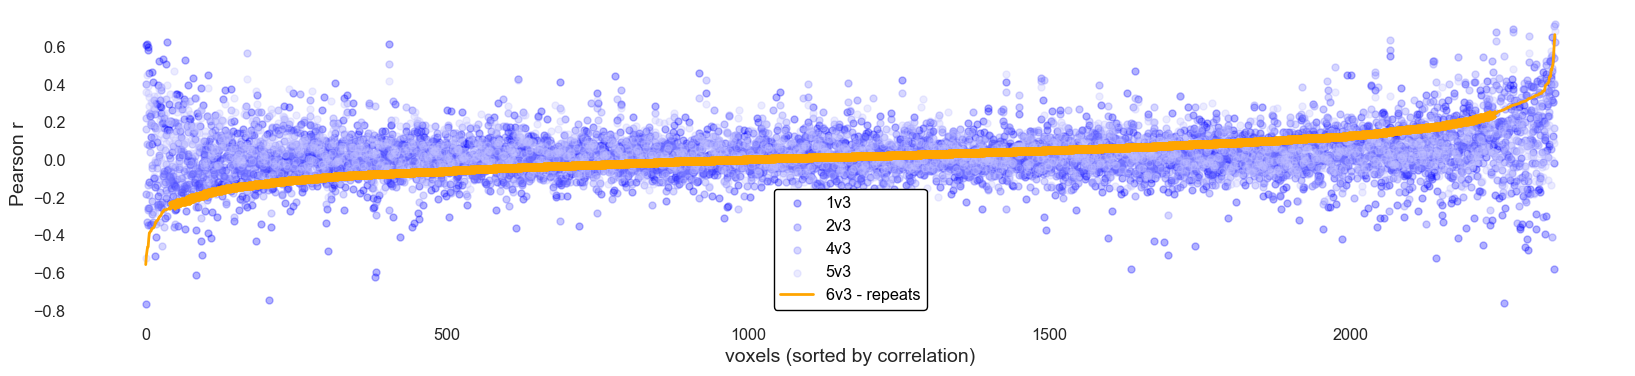

In [162]:
crop_at = 296 # need all runs to match in length to get correlation. Cropping by duration of shortest run
n_voxels = runs_fmri[1].shape[1]
rs, ps, sorted_voxels, sig_voxels = [], [], [], [] # correlations, p-values, voxels sorted by correlation, and binary mask of statistically significant voxels
holm_bonferroni_thresholds = 0.05 / np.arange(n_voxels, 0 , -1)
for run in all_run_numbers:
    if run == test_run_numbers[0]:
        rs.append([])
        ps.append([])
        sorted_voxels.append([])
        sig_voxels.append([])
        continue
    r, p = pearsonr(runs_fmri[run][:crop_at, :], runs_fmri[test_run_numbers[0]][:crop_at, :], axis=0)
    sorted_voxels.append(np.argsort(r))
    rs.append(r)
    ps.append(p)

    # Perform Holm-Bonferroni multiple comparisons correction
    p_ranks = np.argsort(np.argsort(ps[-1]))
    p_sorted = sorted(ps[-1])
    sig_test = p_sorted < holm_bonferroni_thresholds
    fail_idx = np.nonzero(~sig_test)[0][0]
    sig_test[fail_idx:] = False
    sig_voxels.append(sig_test[p_ranks])
    print(f'proportion of significant voxels {run}v3 {sig_voxels[-1].sum()/n_voxels}')

# Plot correlations for run 3 vs other runs
fig, ax = plt.subplots(figsize=[20,4])
blues = ['#0000FF', '#4949FF', [], '#7879FF', '#BFBFFF']
x_order = sorted_voxels[test_run_numbers[1] - 1]
for i, run in enumerate(all_run_numbers):
    if run == test_run_numbers[0]:
        continue

    if run != test_run_numbers[1]:
        # ax.plot(np.arange(n_voxels),rs[i][x_order], label=f'{run}v3', c = blues[i])
        ax.scatter(np.arange(n_voxels),rs[i][x_order], label=f'{run}v3', c = blues[i], alpha = 0.3)
        # ax.scatter(np.arange(n_voxels)[~(sig_voxels[i][x_order])], np.array(rs[i][x_order])[~(sig_voxels[i][x_order])], c = blues[i], marker = 'x')
    else:
        ax.plot(np.arange(n_voxels),rs[i][x_order], c = 'orange', label=f'{run}v3 - repeats')
        ax.scatter(np.arange(n_voxels)[~(sig_voxels[i][x_order])], np.array(rs[i][x_order])[~(sig_voxels[i][x_order])], marker = 'x', c = 'orange')

ax.set_xlabel('voxels (sorted by correlation)')
ax.set_ylabel('Pearson r')
ax.legend()
plt.show()

In [163]:
save_dir = join(figure_dir, 'run3v6corr')
os.makedirs(save_dir, exist_ok = True)
fig.savefig(join(save_dir, f'{ROI}.png'))

In [164]:
# Create a correlation matrix
n_runs = len(all_run_numbers)
n_voxels = runs_fmri[train_run_numbers[0]].shape[1]
corr_matrix = np.zeros((n_voxels, n_runs, n_runs))

# Fill the correlation matrix
for i, run1 in tqdm(enumerate(all_run_numbers)):
    for j, run2 in enumerate(all_run_numbers):
        if i == j:
            # Diagonal elements are 1 (correlation with self)
            corr_matrix[:, i, j] = 1.0
        else:
            # Calculate Pearson correlation
            r, p = pearsonr(runs_fmri[run1][:crop_at, :], runs_fmri[run2][:crop_at, :], axis=0)
            corr_matrix[:, i, j] = r

6it [00:00,  9.49it/s]


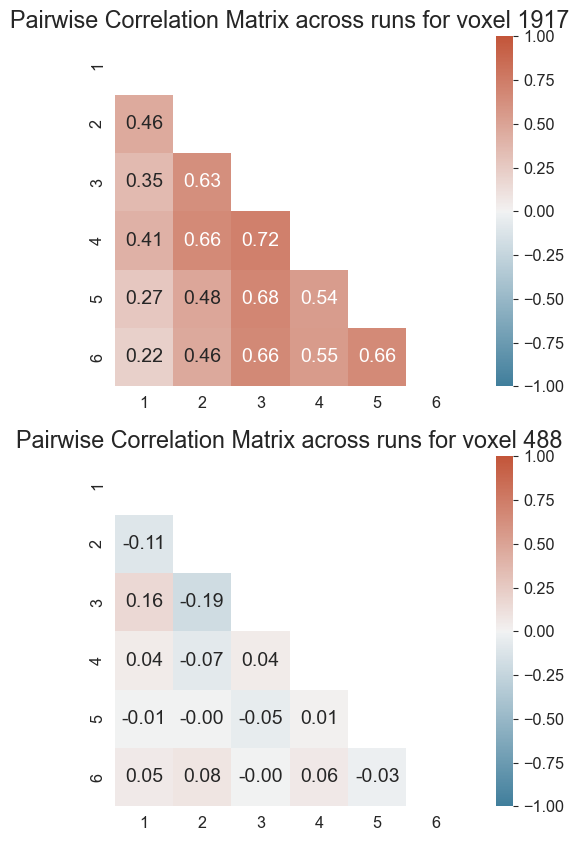

In [165]:
# Sort by correlation between run 3 and 6
reliable_voxels = np.argsort(abs(corr_matrix[:, 2, 5]))[::-1]
example_voxels = [reliable_voxels[0], reliable_voxels[-1]]

# Set up the matplotlib figure
fig, axes = plt.subplots(2,1,figsize=(8, 10))
for i, voxel in enumerate(example_voxels):
    corr_matrix_voxel = corr_matrix[voxel]
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix_voxel, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix_voxel, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0,
                square=True, annot=True, fmt='.2f',
                ax=axes[i])

    # Set plot labels
    axes[i].set_title(f'Pairwise Correlation Matrix across runs for voxel {voxel}')
    axes[i].set_xticks(np.arange(n_runs) + 0.5, all_run_numbers)
    axes[i].set_yticks(np.arange(n_runs) + 0.5, all_run_numbers)
plt.show()

In [166]:
save_dir = join(figure_dir, 'run3v6corr')
os.makedirs(save_dir, exist_ok = True)
fig.savefig(join(save_dir, f'{ROI}_mat.png'))

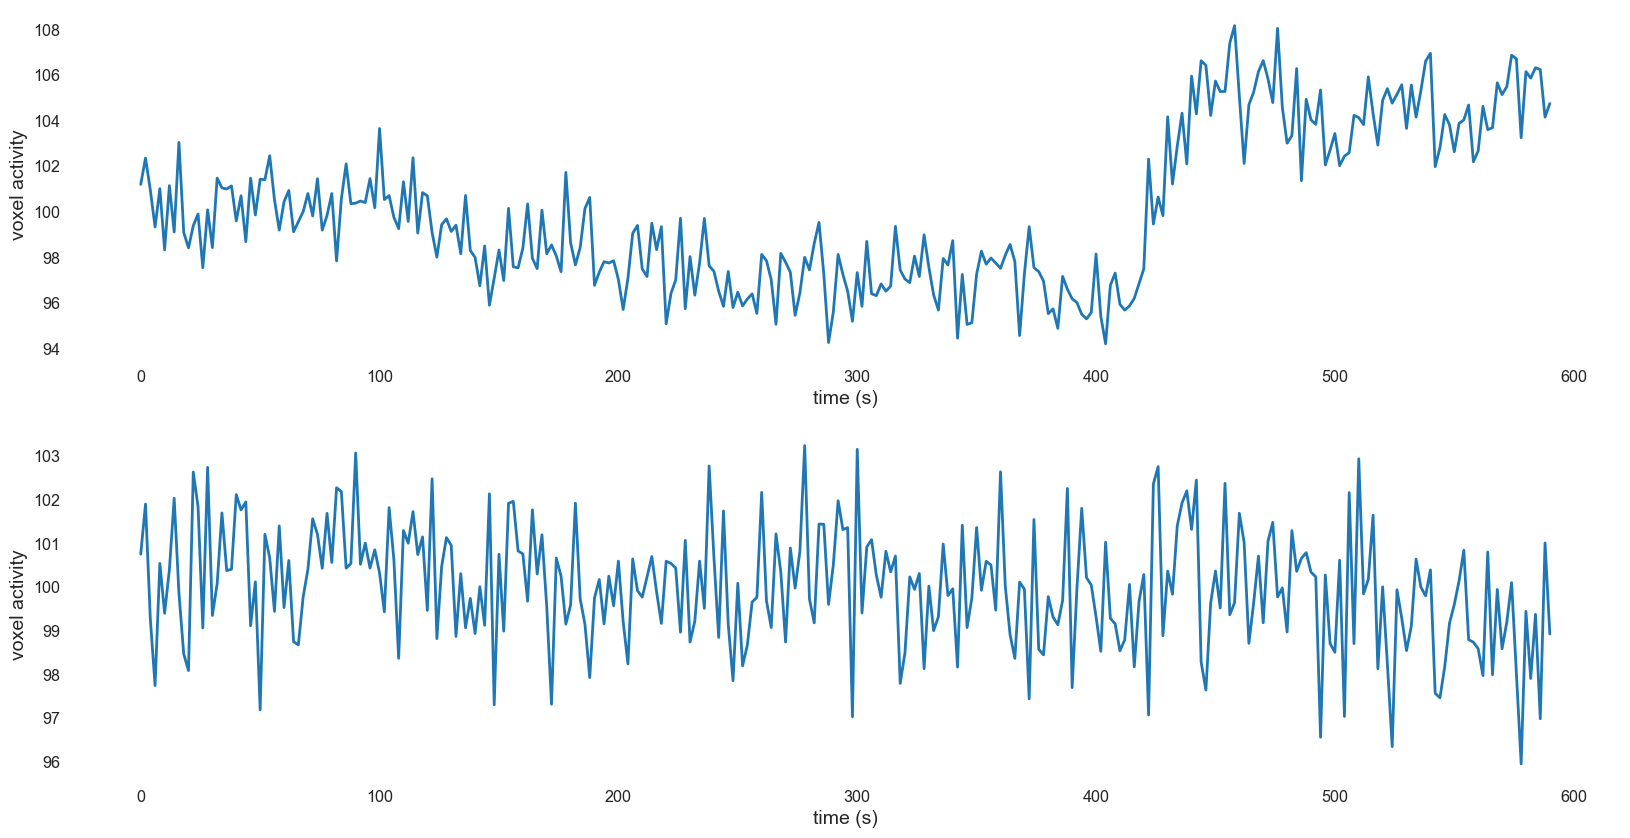

In [167]:
# Show timecourse of select voxels
fig, axes = plt.subplots(2,1,figsize=(20, 10))
run_number = 1
TR = 2
for i, voxel in enumerate(example_voxels):
    timeseries = runs_fmri[run_number][:,voxel]
    axes[i].plot(np.arange(timeseries.shape[0])*TR, timeseries)
    axes[i].set_xlabel("time (s)")
    axes[i].set_ylabel("voxel activity")

In [168]:
fig.savefig(join(figure_dir, 'voxel_time.png'))

Going forward, one might want to consider only focusing on the voxels with significant correlations between runs 3 and 6.

### (OPTIONAL) Average repeated test run
Runs 3 and 6 are repeats, to use as the test set

In [5]:
# test_data = np.array([runs_data[str(i)] for i in test_run_numbers])
# print('Test set BEFORE averaging:',test_data.shape)
# test_data = test_data.mean(axis=0)
# print('Test set AFTER averaging:',test_data.shape)
#
#
# # Delete references to run 6, overwrite run 3 as average of test sets,
# runs_data['3'] = test_data
# del runs_data['6']
# test_run_numbers = ['3']
# all_run_numbers = sorted(train_run_numbers + test_run_numbers)
#
# print('train_run_numbers :', train_run_numbers)
# print('test_run_numbers :', test_run_numbers)
# print('all_run_numbers :', all_run_numbers)
# print('runs_data.keys() :', runs_data.keys())

Test set BEFORE averaging: (2, 298, 237332)
Test set AFTER averaging: (298, 237332)
train_run_numbers : ['1', '2', '4', '5']
test_run_numbers : ['3']
all_run_numbers : ['1', '2', '3', '4', '5']
runs_data.keys() : dict_keys(['1', '2', '3', '4', '5'])


# Load Frames Stimuli

In [33]:
runs_frames = {}
skip_frames = 4 # For memory reasons, set this to only load in every skip_frames frames
for run_number in all_run_numbers:
    imgs = []
    run_path = join(frames_dir,f'run{run_number}')
    if run_number == test_run_numbers[1]:
        runs_frames[test_run_numbers[1]] = runs_frames[test_run_numbers[0]]
        break
    for filename in tqdm(os.listdir(run_path)[::skip_frames]):
        if filename.endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):  # Supported formats
            img_path = join(run_path, filename)
            img = Image.open(img_path).convert("RGB")  # Convert to RGB (optional)
            imgs.append(img)
    runs_frames[run_number] = np.array(imgs)

100%|██████████| 571/571 [00:15<00:00, 37.58it/s]


Generate gif from frames of video stimulus

In [265]:
run_number = 1
imgs = [Image.fromarray(img) for img in runs_frames[run_number]][:50]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save(f"run{run_number}_stimulus.gif", save_all=True, append_images=imgs[1:], duration=1/FPS*1000, loop=0)

# Load Embeddings
## CLIP

In [37]:
# Get embeddings from CLIP
# Load the pretrained model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", use_fast = True)
runs_CLIP = defaultdict(list)
for run_number in all_run_numbers:
    if run_number == test_run_numbers[1]:
        runs_CLIP[test_run_numbers[1]] = runs_CLIP[test_run_numbers[0]]
        break
    for img in tqdm(runs_frames[run_number]):
        inputs = processor(images=img, return_tensors="pt")
        with torch.no_grad():  # No need for gradients
            image_features = model.get_image_features(**inputs)

        # Normalize the embeddings (useful for similarity comparisons)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Convert to numpy if needed
        embedding = image_features.cpu().numpy().flatten().squeeze()
        runs_CLIP[run_number].append(embedding)
    runs_CLIP[run_number] = np.array(runs_CLIP[run_number])

100%|██████████| 571/571 [00:31<00:00, 18.05it/s]


### Delay features

In [38]:
# Taken from speechmodeltutorial
def delay_mat(stim, delays, circpad=False):
    """Creates non-interpolated concatenated delayed versions of [stim] with the given [delays]
    (in samples).

    If [circpad], instead of being padded with zeros, [stim] will be circularly shifted.
    """
    nt,ndim = stim.shape
    dstims = []
    for di,d in enumerate(delays):
        dstim = np.zeros((nt, ndim))
        if d<0: ## negative delay
            dstim[:d,:] = stim[-d:,:]
            if circpad:
                dstim[d:,:] = stim[:-d,:]
        elif d>0:
            dstim[d:,:] = stim[:-d,:]
            if circpad:
                dstim[:d,:] = stim[-d:,:]
        else: ## d==0
            dstim = stim.copy()
        dstims.append(dstim)
    return np.hstack(dstims)

delays = np.arange(1,5) * 2
runs_CLIP_delayed = defaultdict(list)
for run_number in all_run_numbers:
    if run_number == test_run_numbers[1]:
        runs_CLIP_delayed[test_run_numbers[1]] = runs_CLIP_delayed[test_run_numbers[0]]
        break
    runs_CLIP_delayed[run_number] = delay_mat(runs_CLIP[run_number], delays)

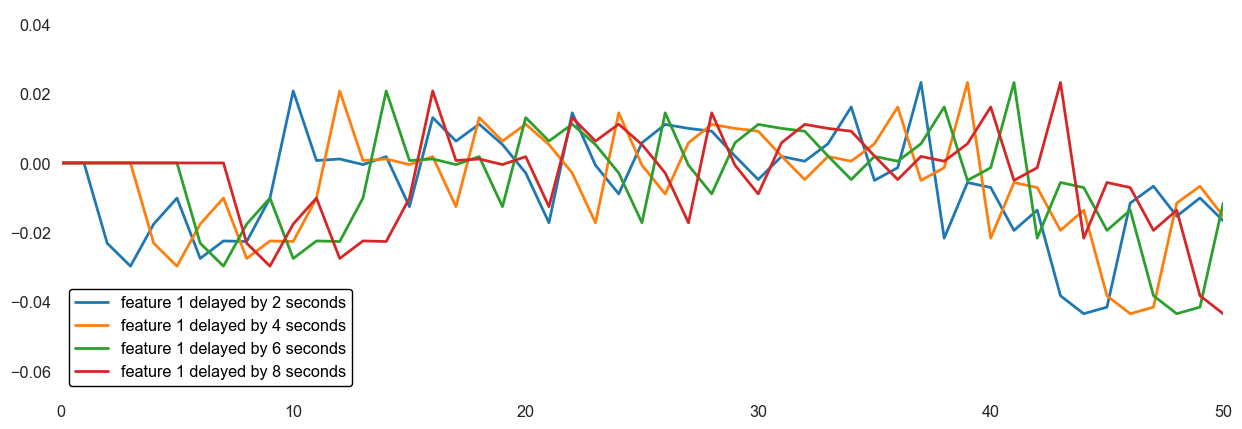

In [39]:
size_embedding = 512
run = 1
x = np.arange(runs_CLIP_delayed[run].shape[0])
feat_idx = 0
fig = plt.figure(figsize=(15,5))
plt.plot(x, runs_CLIP_delayed[run][:,feat_idx],label = 'feature 1 delayed by 2 seconds')
plt.plot(x, runs_CLIP_delayed[run][:,feat_idx + size_embedding],label = 'feature 1 delayed by 4 seconds')
plt.plot(x, runs_CLIP_delayed[run][:,feat_idx + 2 * size_embedding],label = 'feature 1 delayed by 6 seconds')
plt.plot(x, runs_CLIP_delayed[run][:,feat_idx + 3 * size_embedding],label = 'feature 1 delayed by 8 seconds')
plt.xlim([0, 50])
plt.legend()
plt.show()

In [40]:
fig.savefig(join(figure_dir, 'delayed_CLIP.png'))

## R3M

In [11]:
#LOAD MODEL
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
r3m = load_r3m("resnet50") # resnet18, resnet34, resnet50
r3m.eval()
r3m.to(device)

## DEFINE PREPROCESSING
transforms = T.Compose([T.Resize(256),
    T.CenterCrop(224), #NOTE even if you don't crop the image, the model will crop to 224x224!
    T.ToTensor()]) # ToTensor() divides by 255

runs_R3M = defaultdict(list)
for run_number in all_run_numbers:
    if run_number == test_run_numbers[1]:
        runs_R3M[test_run_numbers[1]] = runs_R3M[test_run_numbers[0]]
        break
    for img in tqdm(runs_frames[run_number]):
        preprocessed = transforms(Image.fromarray(img, 'RGB')).reshape(-1, 3, 224, 224)
        preprocessed = preprocessed.to(device)

        # Get embedding
        with torch.no_grad():
            embedding = r3m(preprocessed * 255.0)

        # Convert to numpy if needed
        embedding = embedding.cpu().numpy()[0].flatten().squeeze()
        runs_R3M[run_number].append(embedding)
    runs_R3M[run_number] = np.array(runs_R3M[run_number])

C:\Users\noush\miniconda3\envs\xaqlab2\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
C:\Users\noush\miniconda3\envs\xaqlab2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\noush\miniconda3\envs\xaqlab2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 571/571 [00:22<00:00, 25.20it/s]


In [12]:
delays = np.arange(1,5) * 2
runs_R3M_delayed = defaultdict(list)
for run_number in all_run_numbers:
    if run_number == test_run_numbers[1]:
        runs_R3M_delayed[test_run_numbers[1]] = runs_R3M_delayed[test_run_numbers[0]]
        break
    runs_R3M_delayed[run_number] = delay_mat(runs_R3M[run_number], delays)

## RESNET50

In [13]:
resnet = resnet50(pretrained=True).to(device) #https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50
resnet.eval()
runs_resnet50 = defaultdict(list)
for run_number in all_run_numbers:
    if run_number == test_run_numbers[1]:
        runs_resnet50[test_run_numbers[1]] = runs_resnet50[test_run_numbers[0]]
        break
    for img in tqdm(runs_frames[run_number]):
        preprocessed = transforms(Image.fromarray(img, 'RGB')).reshape(-1, 3, 224, 224)
        preprocessed = preprocessed.to(device)

        # Get embedding
        with torch.no_grad():
            embedding = resnet(preprocessed * 255.0)

        # Convert to numpy if needed
        embedding = embedding.cpu().numpy()[0].flatten().squeeze()
        runs_resnet50[run_number].append(embedding)
    runs_resnet50[run_number] = np.array(runs_resnet50[run_number])

C:\Users\noush\miniconda3\envs\xaqlab2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 571/571 [00:22<00:00, 25.39it/s]


In [14]:
delays = np.arange(1,5) * 2
runs_resnet50_delayed = defaultdict(list)
for run_number in all_run_numbers:
    if run_number == test_run_numbers[1]:
        runs_resnet50_delayed[test_run_numbers[1]] = runs_resnet50_delayed[test_run_numbers[0]]
        break
    runs_resnet50_delayed[run_number] = delay_mat(runs_resnet50[run_number], delays)

## GPT2

## Load Narrations

In [47]:
# Load annotations
runs_narration = pd.read_csv(join(data_dir, 'video_annotation_data.csv')).dropna()
runs_narration['start_frame'] = runs_narration['start_frame'].astype(int)
runs_narration['stop_frame'] = runs_narration['stop_frame'].astype(int)
runs_narration['start_TR'] = (runs_narration['run_start_seconds'] // TR).astype(int)
runs_narration['stop_TR'] = (runs_narration['run_stop_seconds'] // TR).astype(int)

# Select words to analyze
bad_words = ['bottle:nesquik', 'spoon:wooden', 'cupboard:strainer', 'tap:water', 'package:pizza', 'box:pizza', 'skin:onion', 'package:bacon', 'bag:spaghetti', 'package:cream', 'pack:cheese', 'glove:oven']
bad_to_good_words = dict(zip(bad_words, ['bottle', 'spoon', 'cupboard', 'water', 'pizza', 'pizza', 'onion', 'bacon', 'spaghetti', 'cream', 'cheese', 'oven']))
nouns = list(filter(lambda s: s not in bad_words, runs_narration['noun'].unique()))
verbs = runs_narration['verb'].unique()

In [53]:
# Load model and tokenizer
layer = 12
model_name = "gpt2"  # Change to your desired model
tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
embedding_layer = model.get_input_embeddings()

# Get text embeddings
runs_GPT2 = defaultdict(lambda: defaultdict(list))
for x in runs_narration.itertuples():
    run = x.run
    start_TR = x.start_TR
    stop_TR = x.stop_TR
    noun = x.noun
    verb = x.verb
    if noun in bad_words:
        noun = bad_to_good_words[noun]
    if verb in bad_words:
        verb = bad_to_good_words[verb]
    for tr in range(stop_TR, start_TR - 1, - 1):
        runs_GPT2[run][tr] += [get_multi_string_embedding([noun, verb], tokenizer, embedding_layer)]

runs_TRs = {}
for run_number in all_run_numbers:
    runs_TRs[run_number] = np.array(sorted(list(runs_GPT2[run_number].keys())))
runs_TRs[test_run_numbers[1]] = runs_TRs[test_run_numbers[0]]

# Align fMRI & embeddings

In [169]:
# Some parameters from the preproc pipeline and psychopy script
preproc_dropped_trs = 2 # 2 trs were dropped from beginning of scan during preproc

startup_blank_screen_secs = 20 # 20 seconds of blank/fixation were presented at the start and end of the video
ending_blank_screen_secs = 20

# Calculate how many TRs to drop from the start and end of each run
nTRs_drop_from_start = int((startup_blank_screen_secs / TR) - preproc_dropped_trs) # Should be 8
nTRs_drop_from_end = int((startup_blank_screen_secs / TR)) # Should be 10

total_TRs_to_drop = nTRs_drop_from_start + nTRs_drop_from_end

print(f'{nTRs_drop_from_start} TRs dropped from the START of each run')
print(f'{nTRs_drop_from_end} TRs dropped from the END of each run')
for run_number in all_run_numbers:
    init_nTR = runs_fmri[run_number].shape[0]
    runs_fmri[run_number] = runs_fmri[run_number][nTRs_drop_from_start:-nTRs_drop_from_end, :] # Drop TRs from start and end of the run

    # Correct runs_TRs to drop any TRs that get dropped as a result of this pre-processing
    runs_TRs[run_number] = runs_TRs[run_number][runs_TRs[run_number] != init_nTR - total_TRs_to_drop]
    out_nTR = runs_fmri[run_number].shape[0]
    assert init_nTR-out_nTR == total_TRs_to_drop

8 TRs dropped from the START of each run
10 TRs dropped from the END of each run


In [170]:
# Get annotated TRs
for run_number, trs in runs_TRs.items():
    trs = np.array(trs).astype(int)
    runs_fmri[run_number] = runs_fmri[run_number][trs[trs < runs_fmri[run_number].shape[0]]]

In [171]:
# Correct
for run_number in runs_fmri.keys():
    print(runs_fmri[run_number].shape)

(193, 2341)
(126, 2341)
(206, 2341)
(224, 2341)
(190, 2341)
(206, 2341)


## Average embeddings in each TR
Only need to do this on embeddings that are taken from frames

In [63]:
def average_embeddings_per_TR(fps, skip_frames, dim_embeddings, TR_length, runs_data, runs_TRs):
    sample_hz = fps/skip_frames
    frames_per_TR = int(sample_hz * TR_length)
    runs_avg = {}
    for run_number, run_data in tqdm(runs_data.items()):
        nTRs = len(runs_TRs[run_number])
        runs_avg[run_number] = np.zeros((nTRs, dim_embeddings))
        tr_list = sorted(runs_TRs[run_number])

        # For each TR in run
        for i, tr in enumerate(tr_list):
            if (tr+1)*frames_per_TR > len(run_data):
                avg_embedding = np.average(run_data[tr*frames_per_TR:], axis = 0)
            else:
                avg_embedding = np.average(run_data[tr*frames_per_TR:(tr+1)*frames_per_TR], axis = 0)
            runs_avg[run_number][i] = avg_embedding
    return runs_avg
runs_CLIP_avg = average_embeddings_per_TR(FPS, skip_frames, 512 * len(delays), TR, runs_CLIP_delayed, runs_TRs)
runs_R3M_avg = average_embeddings_per_TR(FPS, skip_frames, 2048 * len(delays), TR, runs_R3M_delayed, runs_TRs)
runs_resnet50_avg = average_embeddings_per_TR(FPS, skip_frames, 1000 * len(delays), TR, runs_resnet50_delayed, runs_TRs)

100%|██████████| 6/6 [00:00<00:00, 155.02it/s]


In [65]:
# Special case: GPT2 embeddings
delays = np.arange(1,5) * 2
runs_GPT2_avg = defaultdict(list)
for run_number in all_run_numbers:
    if run_number == test_run_numbers[1]:
        runs_GPT2_avg[test_run_numbers[1]] = runs_GPT2_avg[test_run_numbers[0]]
        break
    for tr in runs_TRs[run_number]:
        embeds = runs_GPT2[run_number][tr]
        runs_GPT2_avg[run_number].append(np.average(embeds, axis = 0).squeeze())
    runs_GPT2_avg[run_number] = delay_mat(np.array(runs_GPT2_avg[run_number]), delays)

# (OPTIONAL) Save Data

In [172]:
with open(join(data_dir, f'runs_fmri_{ROI}.pkl'), 'wb') as f:
    pickle.dump(runs_fmri, f)
with open(join(data_dir, f'runs_img_{ROI}.pkl'), 'wb') as f:
    pickle.dump(runs_img, f, protocol=pickle.HIGHEST_PROTOCOL)
# with open(join(data_dir, 'runs_CLIP_avg.pkl'), 'wb') as f:
#     pickle.dump(runs_CLIP_avg, f)
# with open(join(data_dir, 'runs_R3M_avg.pkl'), 'wb') as f:
#     pickle.dump(runs_R3M_avg, f)
# with open(join(data_dir, 'runs_resnet50_avg.pkl'), 'wb') as f:
#     pickle.dump(runs_resnet50_avg, f)
# with open(join(data_dir, 'runs_GPT2_avg.pkl'), 'wb') as f:
#     pickle.dump(runs_GPT2_avg, f)

# (OPTIONAL) Load pre-computed data

In [35]:
with open(join(data_dir, f'runs_fmri_{ROI}.pkl'), 'rb') as f:
    runs_fmri = pickle.load(f)
with open(join(data_dir, 'runs_CLIP_avg.pkl'), 'rb') as f:
    runs_CLIP_avg = pickle.load(f)
with open(join(data_dir, 'runs_R3M_avg.pkl'), 'rb') as f:
    runs_R3M_avg = pickle.load(f)
with open(join(data_dir, 'runs_resnet50_avg.pkl'), 'rb') as f:
    runs_resnet50_avg = pickle.load(f)
with open(join(data_dir, 'runs_GPT2_avg.pkl'), 'rb') as f:
    runs_GPT2_avg = pickle.load(f)

In [7]:
with open(join(data_dir, f'runs_img_{ROI}.pkl'), 'rb') as f:
    runs_img = pickle.load(f)

# RSA

Get individual RDMs across models and runs

In [173]:
%%capture
def rdm_heatmap(embeddings, model_name, plot = True, return_rdm = True,
    cmap='flare', figsize=(10, 8), save_path=None):
    """
    Plots a dendrogram and a heatmap for the given embeddings.
    """
    # RDM for embeddings
    embedding_distances = pdist(embeddings, metric='correlation') #NOTE we don't reorder the embeddings here, and all the embeddings have same order, so we can directly compare these to do RSA
    embedding_rdm = squareform(embedding_distances)

    # embedding_rdm_df = pd.DataFrame(embedding_rdm)
    if plot:
        plt.figure(figsize=figsize)
        _ = sns.heatmap(embedding_rdm, cbar=True, cmap = cmap)
        plt.title(f"Representational Dissimilarity Matrix (RDM) of {model_name} embeddings")
        plt.xlabel("Stimuli")
        plt.ylabel("Stimuli")

        # Save or show the plot
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()
    if return_rdm:
        return embedding_rdm
rdms = {
    'CLIP': [],
    'R3M': [],
    'RESNET50': [],
    'GPT2': [],
    'fMRI': []
}

def triangle(arr):
    return arr[np.triu_indices(arr.shape[0], k = 1)]

for i in all_run_numbers:
    rdms['CLIP'].append(triangle(rdm_heatmap(runs_CLIP_avg[i], 'CLIP delayed', save_path = join(figure_dir, f'CLIP_rdm_run{i}'))))
    rdms['R3M'].append(triangle(rdm_heatmap(runs_R3M_avg[i], 'R3M delayed', save_path = join(figure_dir, f'R3M_rdm_run{i}'))))
    rdms['RESNET50'].append(triangle(rdm_heatmap(runs_resnet50_avg[i], 'RESNET50 delayed', save_path = join(figure_dir, f'resnet50_rdm_run{i}'))))
    rdms['GPT2'].append(triangle(rdm_heatmap(runs_GPT2_avg[i], 'GPT2 delayed', save_path = join(figure_dir, f'GPT2_rdm_run{i}'))))
    rdms['fMRI'].append(triangle(rdm_heatmap(runs_fmri[i], 'fMRI delayed', save_path = join(figure_dir, f'fMRI_rdm_run{i}'))))

Compute the spearman correlation across all models' RDMs. For fMRI x fMRI, only run 3 and 6 are considered. For the rest, only runs 1-5 are considered.

In [174]:
rsa_matrix = np.zeros((len(rdms), len(rdms)))
mdls = list(rdms.keys())
for i in range(len(mdls)):
    for j in range(i, len(mdls)):
        if mdls[i] == mdls[j]:
            if mdls[i] == 'fMRI' and mdls[j] == 'fMRI':
                rsa_matrix[i,j] = spearmanr(rdms['fMRI'][2], rdms['fMRI'][5], nan_policy = 'omit').statistic
            continue
        rep1 = np.concatenate(rdms[mdls[i]][:5])
        rep2 = np.concatenate(rdms[mdls[j]][:5])
        rsa_matrix[i, j] = spearmanr(rep1, rep2, nan_policy = 'omit').statistic

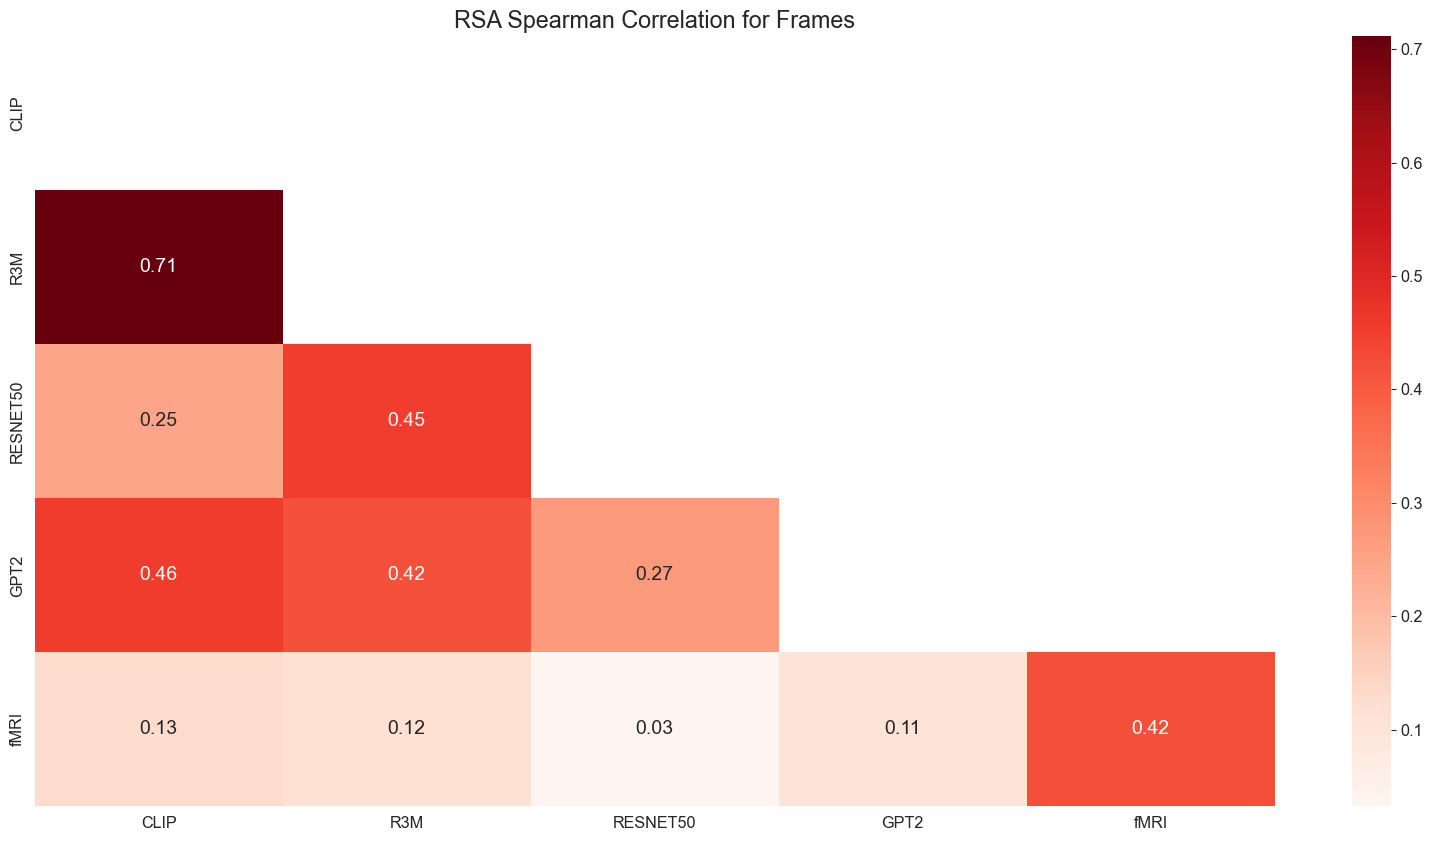

In [175]:
mask = np.triu(np.ones_like(rsa_matrix, dtype=bool))
mask[-1,-1] = False
fig = plt.figure()
sns.heatmap(rsa_matrix.T, annot=True, fmt=".2f", cmap="Reds",
xticklabels=mdls, yticklabels=mdls, mask = mask)
plt.title("RSA Spearman Correlation for Frames")
plt.show()

In [176]:
save_dir = join(figure_dir, 'RSA')
os.makedirs(save_dir, exist_ok = True)
fig.savefig(join(save_dir, f'rsa_{ROI}.png'))

## Significant voxels

In [177]:
%%capture

rdms_sig = {
    'CLIP': [],
    'R3M': [],
    'RESNET50': [],
    'GPT2': [],
    'fMRI': []
}

for i in all_run_numbers:
    selected_voxels = sig_voxels[i-1]
    if i == test_run_numbers[0]:
        selected_voxels = sig_voxels[-1]
    rdms_sig['fMRI'].append(triangle(rdm_heatmap(runs_fmri[i][:,selected_voxels], 'fMRI delayed (significant voxels)', save_path = join(figure_dir, f'fMRI_rdm_run{i}_sig'))))

rdms_sig['CLIP'] = rdms['CLIP']
rdms_sig['R3M'] = rdms['R3M']
rdms_sig['RESNET50'] = rdms['RESNET50']
rdms_sig['GPT2'] = rdms['GPT2']

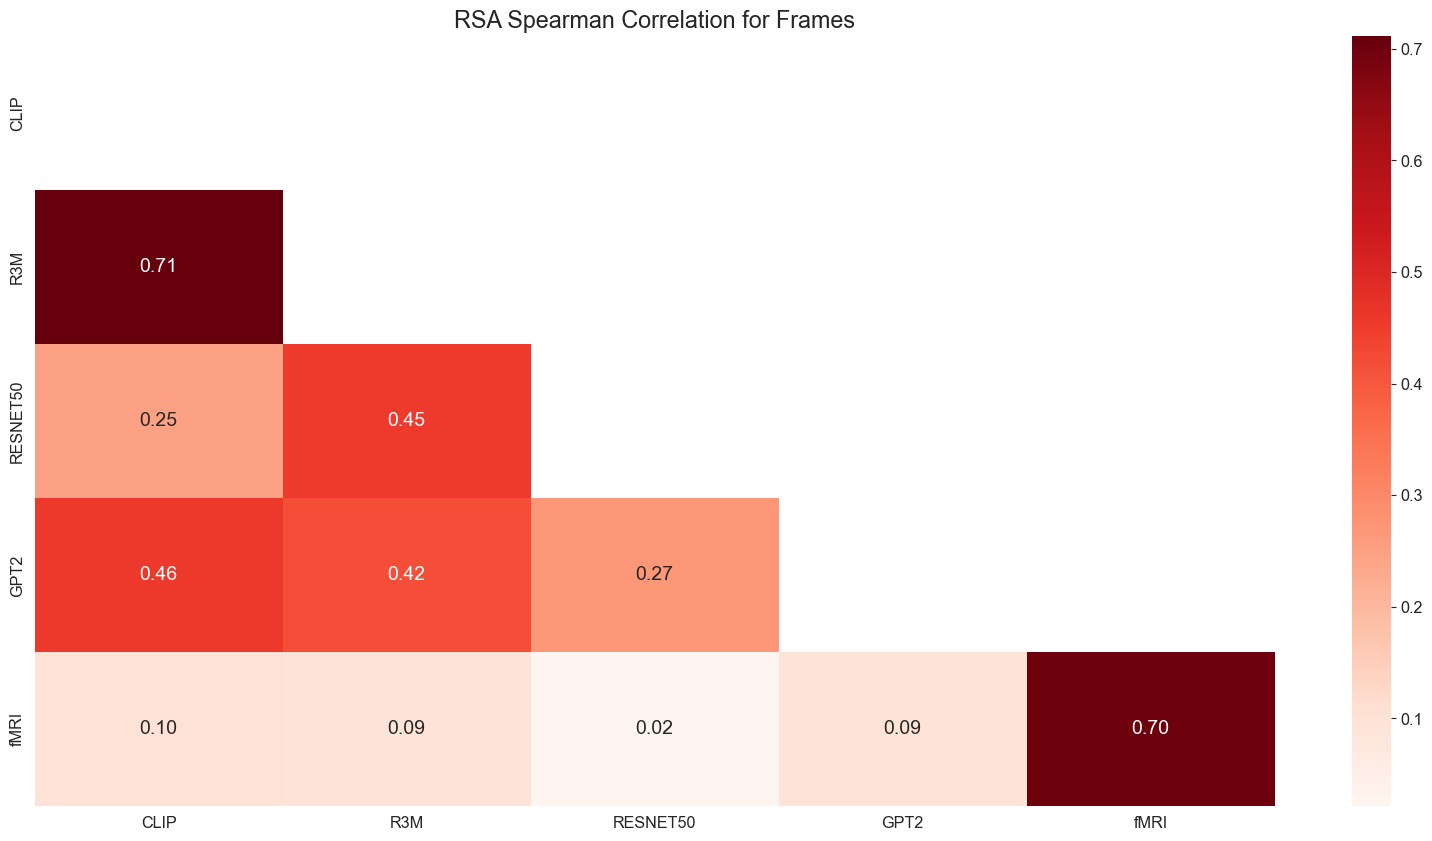

In [178]:
rsa_matrix_sig = np.zeros((len(rdms), len(rdms)))
mdls = list(rdms.keys())
for i in range(len(mdls)):
    for j in range(i, len(mdls)):
        if mdls[i] == mdls[j]:
            if mdls[i] == 'fMRI' and mdls[j] == 'fMRI':
                rsa_matrix_sig[i,j] = spearmanr(rdms_sig['fMRI'][2], rdms_sig['fMRI'][5], nan_policy = 'omit').statistic
            continue
        rep1 = np.concatenate(rdms_sig[mdls[i]][:5])
        rep2 = np.concatenate(rdms_sig[mdls[j]][:5])
        rsa_matrix_sig[i, j] = spearmanr(rep1, rep2, nan_policy = 'omit').statistic

mask = np.triu(np.ones_like(rsa_matrix_sig, dtype=bool))
mask[-1,-1] = False
fig = plt.figure()
sns.heatmap(rsa_matrix_sig.T, annot=True, fmt=".2f", cmap="Reds",
xticklabels=mdls, yticklabels=mdls, mask = mask)
plt.title("RSA Spearman Correlation for Frames")
plt.show()

In [179]:
save_dir = join(figure_dir, 'RSA')
os.makedirs(save_dir, exist_ok = True)
fig.savefig(join(save_dir, f'rsa_sig_{ROI}.png'))

## Permutation Test

In [180]:
def triangle(arr):
    return arr[np.triu_indices(arr.shape[0], k = 1)]

def permute_rdm(mat, rng = np.random.default_rng(SEED)):
    n = mat.shape[0]
    # Create permutation
    perm = rng.permutation(n)
    return mat[perm, :]

rdms_full = {
    'CLIP': [],
    'R3M': [],
    'RESNET50': [],
    'GPT2': [],
    'fMRI': []
}

def triangle(arr):
    return arr[np.triu_indices(arr.shape[0], k = 1)]

for i in all_run_numbers:
    rdms_full['CLIP'].append(rdm_heatmap(runs_CLIP_avg[i], 'CLIP delayed', plot = False))
    rdms_full['R3M'].append(rdm_heatmap(runs_R3M_avg[i], 'R3M delayed',  plot = False))
    rdms_full['RESNET50'].append(rdm_heatmap(runs_resnet50_avg[i], 'RESNET50 delayed',  plot = False))
    rdms_full['GPT2'].append(rdm_heatmap(runs_GPT2_avg[i], 'GPT2 delayed',  plot = False))
    rdms_full['fMRI'].append(rdm_heatmap(runs_fmri[i], 'fMRI delayed',  plot = False))

def permute_rsa(rdms, rdms_full, n_perms = 20, seed = SEED):

    rsa_matrix_perm = np.zeros((n_perms, len(rdms), len(rdms)))
    rng = np.random.default_rng(SEED)
    for p in tqdm(range(n_perms)):
        rdms_perm = {
            'CLIP': [],
            'R3M': [],
            'RESNET50': [],
            'GPT2': [],
            'fMRI': []
        }

        for i in all_run_numbers:
            rdms_perm['CLIP'].append(triangle(permute_rdm(rdms_full['CLIP'][i - 1], rng)))
            rdms_perm['R3M'].append(triangle(permute_rdm(rdms_full['R3M'][i - 1], rng)))
            rdms_perm['RESNET50'].append(triangle(permute_rdm(rdms_full['RESNET50'][i - 1], rng)))
            rdms_perm['GPT2'].append(triangle(permute_rdm(rdms_full['GPT2'][i - 1], rng)))
            rdms_perm['fMRI'].append(triangle(permute_rdm(rdms_full['fMRI'][i - 1], rng)))

        mdls = list(rdms_perm.keys())
        for i in range(len(mdls)):
            for j in range(i, len(mdls)):
                if mdls[i] == mdls[j]:
                    if mdls[i] == 'fMRI' and mdls[j] == 'fMRI':
                        rsa_matrix_perm[p, i,j] = spearmanr(rdms['fMRI'][2], rdms_perm['fMRI'][5], nan_policy = 'omit').statistic
                    continue
                rep1 = np.concatenate(rdms[mdls[i]][:5])
                rep2 = np.concatenate(rdms_perm[mdls[j]][:5])
                rsa_matrix_perm[p, i, j] = spearmanr(rep1, rep2, nan_policy = 'omit').statistic
    return rsa_matrix_perm
rsa_matrix_perms = permute_rsa(rdms, rdms_full)

100%|██████████| 20/20 [06:36<00:00, 19.81s/it]


In [181]:
print(np.average((rsa_matrix[np.newaxis,:,:] > rsa_matrix_perms).astype(int), axis = 0)) # How may times were the correlations greater than the permutations?

[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


# Junk

In [83]:
# Map each embedding TR to narration label
noun_embeddings = defaultdict(list)
verb_embeddings = defaultdict(list)
for x in runs_narration.itertuples():
    run = x.run
    start_TR = x.start_TR
    stop_TR = x.stop_TR
    noun = x.noun
    verb = x.verb
    if noun in bad_words:
        noun = bad_to_good_words[noun]
    if verb in bad_words:
        verb = bad_to_good_words[verb]
    noun_embeddings[noun] += list(runs_embeddings_avg[str(run)][start_TR:(stop_TR+1)])
    verb_embeddings[verb] += list(runs_embeddings_avg[str(run)][start_TR:(stop_TR+1)])

# Do the same for fMRI
noun_fmri = defaultdict(list)
verb_fmri = defaultdict(list)
for x in runs_narration.itertuples():
    run = x.run
    start_TR = x.start_TR
    stop_TR = x.stop_TR
    noun = x.noun
    verb = x.verb
    if noun in bad_words:
        noun = bad_to_good_words[noun]
    if verb in bad_words:
        verb = bad_to_good_words[verb]
    noun_fmri[noun] += list(runs_fmri[str(run)][start_TR:(stop_TR + 1)])
    verb_fmri[verb] += list(runs_fmri[str(run)][start_TR:(stop_TR + 1)])

In [84]:
# Get average embedding for each word
noun_embeddings_avg = {}
verb_embeddings_avg = {}
for noun, embeddings in noun_embeddings.items():
    noun_embeddings_avg[noun] = np.average(embeddings, axis = 0)
for verb, embeddings in verb_embeddings.items():
    verb_embeddings_avg[verb] = np.average(embeddings, axis = 0)

# Do the same for fMRI
noun_fmri_avg = {}
verb_fmri_avg = {}
for noun, embeddings in noun_fmri.items():
    noun_fmri_avg[noun] = np.average(embeddings, axis = 0)
for verb, embeddings in verb_fmri.items():
    verb_fmri_avg[verb] = np.average(embeddings, axis = 0)

Text(95.72222222222221, 0.5, 'Stimuli')

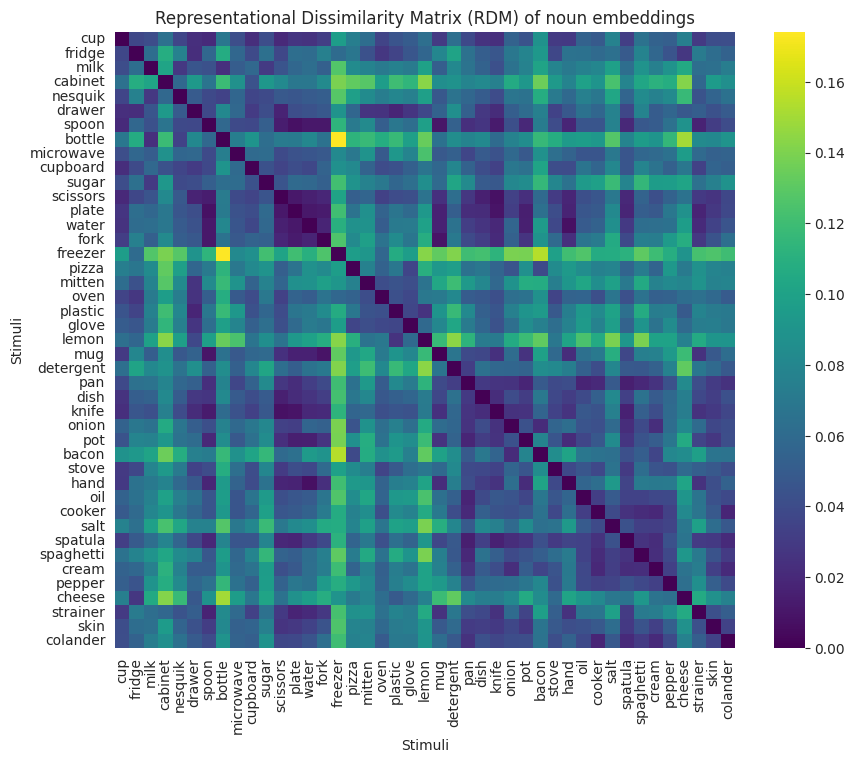

In [81]:
from scipy.spatial.distance import squareform, pdist
# RDM for embeddings
embedding_distances_nouns = pdist(list(noun_embeddings_avg.values()), metric='correlation')
embedding_rdm_nouns = squareform(embedding_distances_nouns)
embedding_rdm_df_nouns = pd.DataFrame(embedding_rdm_nouns, index = noun_embeddings_avg.keys(), columns = noun_embeddings_avg.keys())
plt.figure(figsize=(10,8))
sns.heatmap(embedding_rdm_df_nouns, cmap="viridis", cbar=True, xticklabels=True, yticklabels=True)
plt.title("Representational Dissimilarity Matrix (RDM) of noun embeddings")
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")

Text(95.72222222222221, 0.5, 'Stimuli')

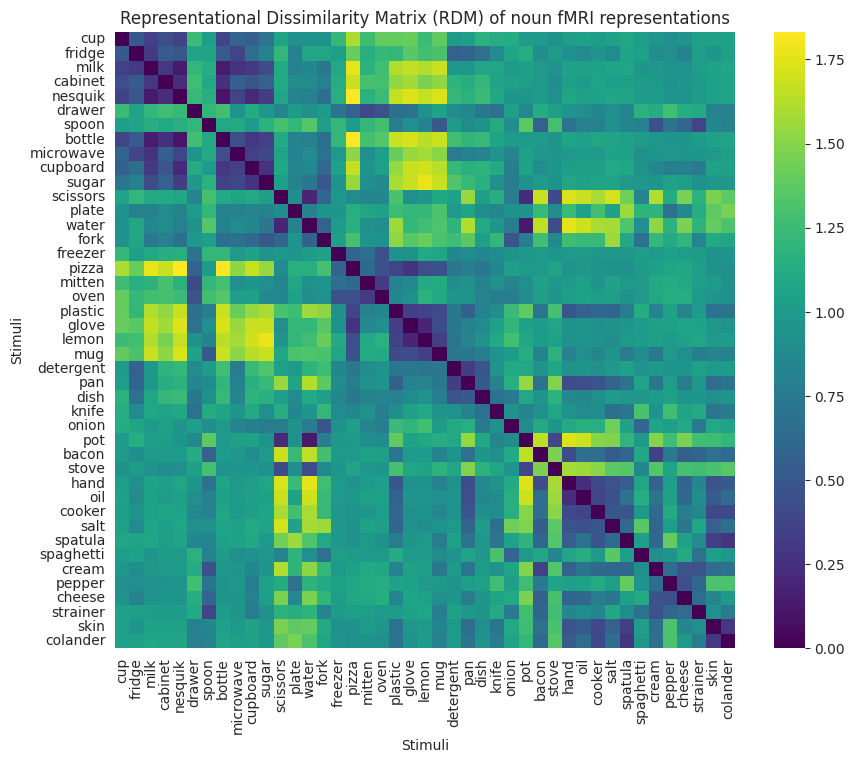

In [87]:
fmri_distances_nouns = pdist(list(noun_fmri_avg.values()), metric='correlation')
fmri_rdm_nouns = squareform(fmri_distances_nouns)
fmri_rdm_df_nouns = pd.DataFrame(fmri_rdm_nouns, index = noun_fmri_avg.keys(), columns = noun_fmri_avg.keys())
plt.figure(figsize=(10,8))
sns.heatmap(fmri_rdm_df_nouns, cmap="viridis", cbar=True, xticklabels=True, yticklabels=True)
plt.title("Representational Dissimilarity Matrix (RDM) of noun fMRI representations")
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")

Text(95.72222222222221, 0.5, 'Stimuli')

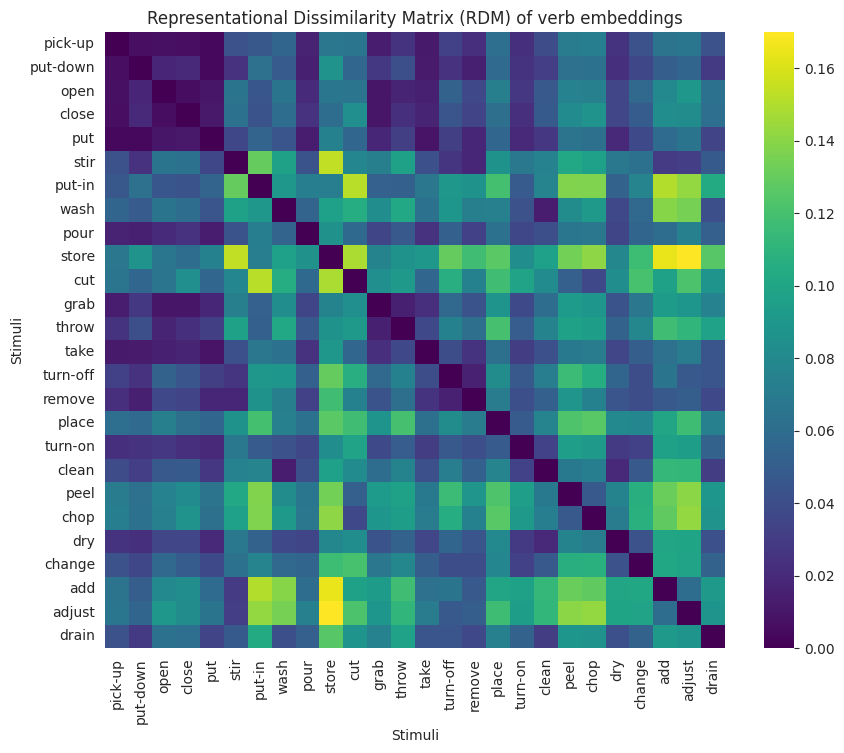

In [88]:
embedding_distances_verbs = pdist(list(verb_embeddings_avg.values()), metric='correlation')
embedding_rdm_verbs = squareform(embedding_distances_verbs)
embedding_rdm_df_verbs = pd.DataFrame(embedding_rdm_verbs, index = verb_embeddings_avg.keys(), columns = verb_embeddings_avg.keys())
plt.figure(figsize=(10,8))
sns.heatmap(embedding_rdm_df_verbs, cmap="viridis", cbar=True, xticklabels=True, yticklabels=True)
plt.title("Representational Dissimilarity Matrix (RDM) of verb embeddings")
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")

Text(95.72222222222221, 0.5, 'Stimuli')

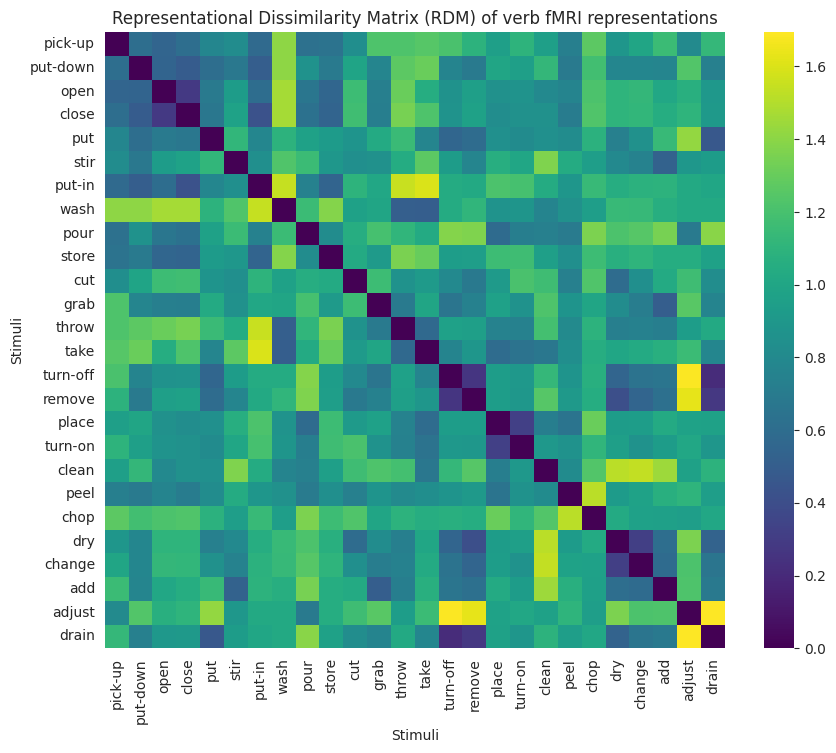

In [89]:
fmri_distances_verbs = pdist(list(verb_fmri_avg.values()), metric='correlation')
fmri_rdm_verbs = squareform(fmri_distances_verbs)
fmri_rdm_df_verbs = pd.DataFrame(fmri_rdm_verbs, index = verb_fmri_avg.keys(), columns = verb_fmri_avg.keys())
plt.figure(figsize=(10,8))
sns.heatmap(fmri_rdm_df_verbs, cmap="viridis", cbar=True, xticklabels=True, yticklabels=True)
plt.title("Representational Dissimilarity Matrix (RDM) of verb fMRI representations")
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")

In [91]:
from scipy.stats import spearmanr
rho, p_value = spearmanr(embedding_rdm_nouns.flatten(), fmri_rdm_nouns.flatten())
print(f"RSA Correlation for nouns (Spearman's rho): {rho:.3f}, p-value: {p_value:.3f}")
rho, p_value = spearmanr(embedding_rdm_verbs.flatten(), fmri_rdm_verbs.flatten())
print(f"RSA Correlation for verbs (Spearman's rho): {rho:.3f}, p-value: {p_value:.3f}")

RSA Correlation for nouns (Spearman's rho): 0.154, p-value: 0.000
RSA Correlation for verbs (Spearman's rho): 0.297, p-value: 0.000


**Make sure all length match: video, annotations, runs**

In [14]:
videos_length_secs = {
                    '1': 559, # 09:19
                    '2': 560, # 09:20,
                    '3': 560, # 09:20,
                    '4': 560, # 09:20,
                    '5': 571, # 09:31
                }

scans_lengths_secs = {run_number : runs_fmri[run_number].shape[0] * TR for run_number in all_run_numbers}
frame_lengths_secs = {run_number : len(runs_embeddings[run_number]) * frames_per_TR for run_number in all_run_numbers}

# Dataframe for nicer visualization
timing_secs = pd.DataFrame([videos_length_secs, scans_lengths_secs, frame_lengths_secs], index = ['video', 'scan', 'frames'])
print('Lengths in seconds')
timing_secs

Lengths in seconds


1    2    3    4    5
video   559  560  560  560  571
scan    556  560  560  560  570
frames  556  560  560  560  570

Since each run's annotations cannot be longer than the scan length, crop the annotation to fit the run length.

**<mark> Important note</mark>** <br> See first comment at the beginning of the script: there are 2 TRs missing from run1, which means we are over-cropping run1 for now. Waiting to hear from Bridge to resolve this (25Mar2025)

In [11]:
print('Cropping')
for run_number in all_run_numbers:
    if frame_lengths_secs[run_number] > scans_lengths_secs[run_number]:
        # drop rows of annot to matc
        nTRs = runs_fmri[run_number].shape[0]
        target_nRows = nTRs * TR * frame_sampling_hz

        print(f'Run{run_number}')
        print('Current num rows:', len(runs_annot[run_number]))
        print('Target num rows:', target_nRows)
        print('')
        _cropped_annot = runs_annot[run_number][:target_nRows] # crop the annotation to get the needed num of rows
        runs_annot[run_number] = _cropped_annot  # overwrite the longer annot.

# Look at new annotation lengths:
frame_lengths_secs = {run_number : len(runs_annot[run_number]) / frame_sampling_hz for run_number in all_run_numbers}

# Datafrane for nicer visualization
timing_secs = pd.DataFrame([videos_length_secs, scans_lengths_secs, frame_lengths_secs], index = ['video', 'scan', 'annot'])
print('------\nNew lengths in seconds')
timing_secs

Cropping
Run1
Current num rows: 2235
Target num rows: 2224

Run5
Current num rows: 2284
Target num rows: 2280

------
New lengths in seconds


1       2      3      4      5
video  559.0  560.00  560.0  560.0  571.0
scan   556.0  560.00  560.0  560.0  570.0
annot  556.0  559.25  559.5  559.5  570.0

### Choose features, z-score, and PCA
**Note:** Here the left and right hand features are processed separately (z-scoring and PCA).

In [12]:
# OUTPUT VARS
runs_feats = {run_number:np.array([]) for run_number in all_run_numbers} # output dict, keys=all_run_numbers, each with shape (n_TRs, n_feats )
feats_legend = [] # list of len=n_feart. list of str to allow me to keep track of what each feature index represents

**Hand landmark features**

For each hand (left/right)
1) z-score features within each run
2) fit PCA across all runs
3) tranform data for all runs


In [13]:
for hand in ['left', 'right']:

    # get the name of the landmarks columns
    features_column_names = [f'hands_{hand}_world_landmark_{i}_{axis}' for i in range(21) for axis in ['x', 'y', 'z']]

    # -- 1) z-score features within each run
    zscored_features_noPCA = {} # intermediate output dict where we will store z-scored features for each run.

    for run_number in all_run_numbers:
        # Get the raw features from this run's annot dataframe
        features = runs_annot[run_number][features_column_names].values

        # Scale the features
        scaled_features = zscore(features)

        # Append the features to the run_feats dict
        zscored_features_noPCA[run_number] = scaled_features

    # -- 2) fit PCA on aggregated z-scored features across all runs
    # create PCA object
    pca = PCA(n_components=0.90)

    # aggregate z-scored features across all runs
    features_all_runs = np.vstack([zscored_features_noPCA[run_number] for run_number in all_run_numbers])

    # fit pca on aggregate data
    pca.fit(features_all_runs)

    # -- 3) Tranform the features of each runs
    for run_number in all_run_numbers:
        transformed_feats = pca.transform(zscored_features_noPCA[run_number])

        # Cant concatenate on the first iteration, when run_feats[run_number] is still an empty list
        if len(runs_feats[run_number]) == 0:
            runs_feats[run_number] = transformed_feats
        else: # If run_feats[run_number] is not empty, concatenate on axis 1
            runs_feats[run_number] = np.concatenate([runs_feats[run_number], transformed_feats], axis=1)

    # --- 4) Update feats_legend list
    feats_legend.extend([f'{hand}_hand_PC_{i}' for i in range(pca.n_components_)])


In [14]:
# make sure shapes are good
print('Features extracted: \n--------------------')
[print(i) for i in feats_legend]

for run_number in all_run_numbers:
    assert runs_feats[run_number].shape[1] == len(feats_legend), f'Shape mismatch {runs_feats[run_number].shape[1]} = {len(feats_legend),}'

Features extracted: 
--------------------
left_hand_PC_0
left_hand_PC_1
left_hand_PC_2
left_hand_PC_3
left_hand_PC_4
left_hand_PC_5
left_hand_PC_6
left_hand_PC_7
right_hand_PC_0
right_hand_PC_1
right_hand_PC_2
right_hand_PC_3
right_hand_PC_4
right_hand_PC_5
right_hand_PC_6
right_hand_PC_7
right_hand_PC_8


**Hand center of bounding box**


Note: This is generalizable, you can add any of the variables from the dataframe into features_column_names.

In [15]:
features_column_names = ['hands_left_bbox_center_x', 'hands_left_bbox_center_y',
                      'hands_right_bbox_center_x', 'hands_right_bbox_center_y']


for run_number in all_run_numbers:
    # Get the raw features from this run's annot dataframe
    features = runs_annot[run_number][features_column_names].values

    # Scale the features
    scaled_features = zscore(features)

    # Append the features to the run_feats dict.
    # Here no need for if statement, since we run_feats is no longer an empty list
    runs_feats[run_number] = np.concatenate([runs_feats[run_number], scaled_features], axis=1)

# Append the feature labels to the feats_legend list. Done outside of loop: one list will refer to all runs.
feats_legend.extend(features_column_names)

In [16]:
# make sure shapes are good
print('Features extracted: \n--------------------')
[print(i) for i in feats_legend]

for run_number in all_run_numbers:
    assert runs_feats[run_number].shape[1] == len(feats_legend)

print('-------------------')
print('run_feats shape for each run: ',runs_feats['1'].shape)
print('len(feats_legend) =', len(feats_legend))

Features extracted: 
--------------------
left_hand_PC_0
left_hand_PC_1
left_hand_PC_2
left_hand_PC_3
left_hand_PC_4
left_hand_PC_5
left_hand_PC_6
left_hand_PC_7
right_hand_PC_0
right_hand_PC_1
right_hand_PC_2
right_hand_PC_3
right_hand_PC_4
right_hand_PC_5
right_hand_PC_6
right_hand_PC_7
right_hand_PC_8
hands_left_bbox_center_x
hands_left_bbox_center_y
hands_right_bbox_center_x
hands_right_bbox_center_y
-------------------
run_feats shape for each run:  (2224, 21)
len(feats_legend) = 21


### Look at feature timecourse

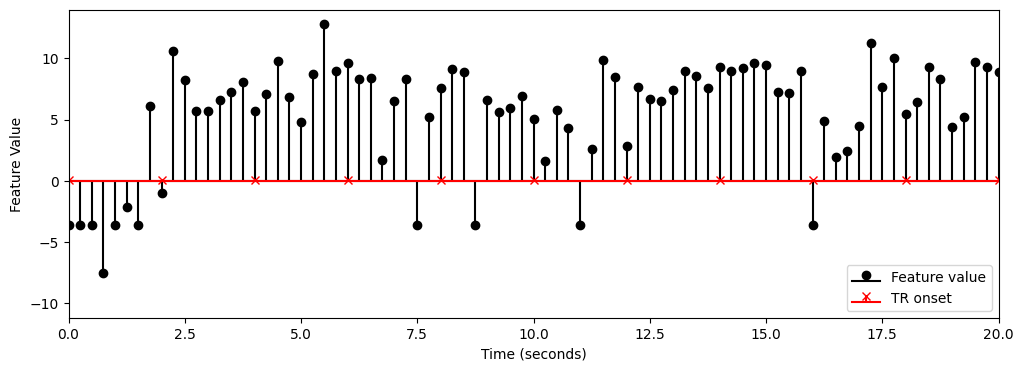

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))
run_number = '3'

# Extract values for one feature feature values
one_feat_values = runs_feats[run_number][:,0]

# Compute TR times
nTRs = runs_fmri[run_number].shape[0]
TR_times_secs = np.arange(nTRs) * TR  # TR is 2 seconds

# Generate x-axis time points for feature values at annot_sampling_hz (4Hz)
xaxis_times_secs = np.arange(len(one_feat_values)) / frame_sampling_hz


# Plot feature values over time
ax.stem(xaxis_times_secs, one_feat_values, linefmt='k-', markerfmt='ko', basefmt='k', label='Feature value')

# Plot TR onset times
ax.stem(TR_times_secs, np.ones(nTRs) * 0.1, linefmt='r-', markerfmt='rx', basefmt='r', label='TR onset')

# Formatting
ax.set_xlim([0, 20])  # Adjust time range as needed
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Feature Value')
ax.legend()

plt.show()


### Lanczos filter: Aligning sampling rates of featues to that of runs (TR).
Perform lanczos filtering to match the sampling rate of the annot with taht of the fmri

<mark>**Note:** If switching to nilearn.FirstLevelModel this is not needed. Skip this section </mark>.

In [18]:
# Look at data shape again
for run_number in all_run_numbers:
    print(f'------- run {run_number} ------')
    print('Features:', runs_feats[run_number].shape)
    print('fmri:', runs_fmri[run_number].shape)

print('\nreminder: at this point to convert from TRs to feature resolution at 4hz: nTrs * Tr * 4hz')

------- run 1 ------
Features: (2224, 21)
fmri: (278, 237332)
------- run 2 ------
Features: (2237, 21)
fmri: (280, 237332)
------- run 3 ------
Features: (2238, 21)
fmri: (280, 237332)
------- run 4 ------
Features: (2238, 21)
fmri: (280, 237332)
------- run 5 ------
Features: (2280, 21)
fmri: (285, 237332)

reminder: at this point to convert from TRs to feature resolution at 4hz: nTrs * Tr * 4hz


Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


/Users/julien/Library/CloudStorage/Dropbox/Work/Projects/Ongoing/natcook/analyses/fMRI/utils/speechmodeltutorial/interpdata.py:161: RuntimeWarning: invalid value encountered in divide
  val = window * np.sin(np.pi*t) * np.sin(np.pi*t/window) / (np.pi**2 * t**2)


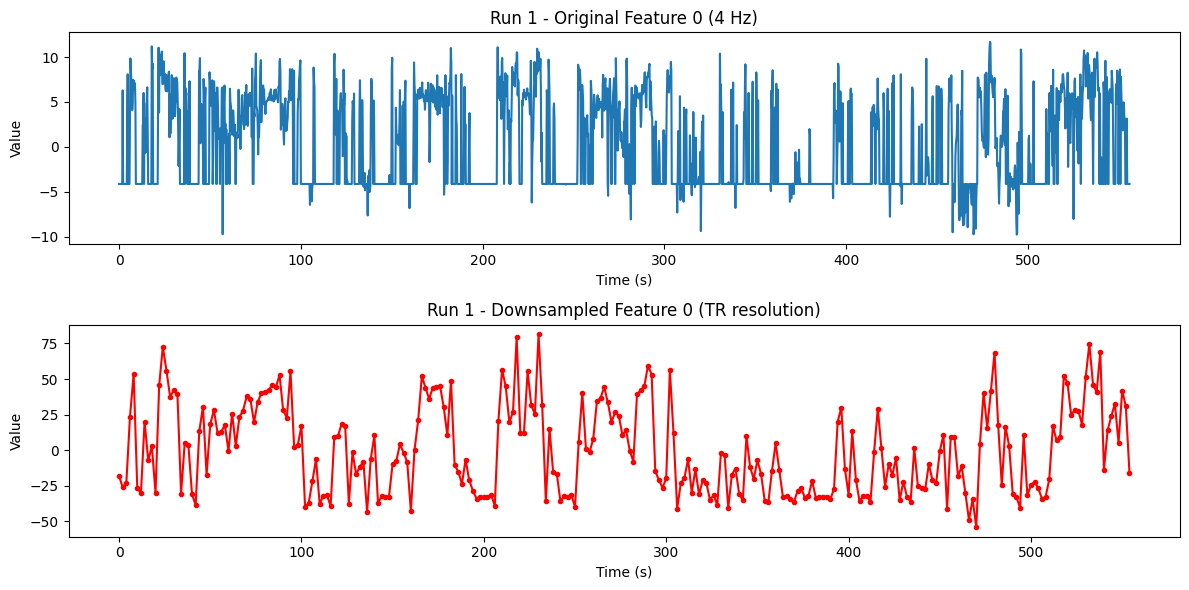

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


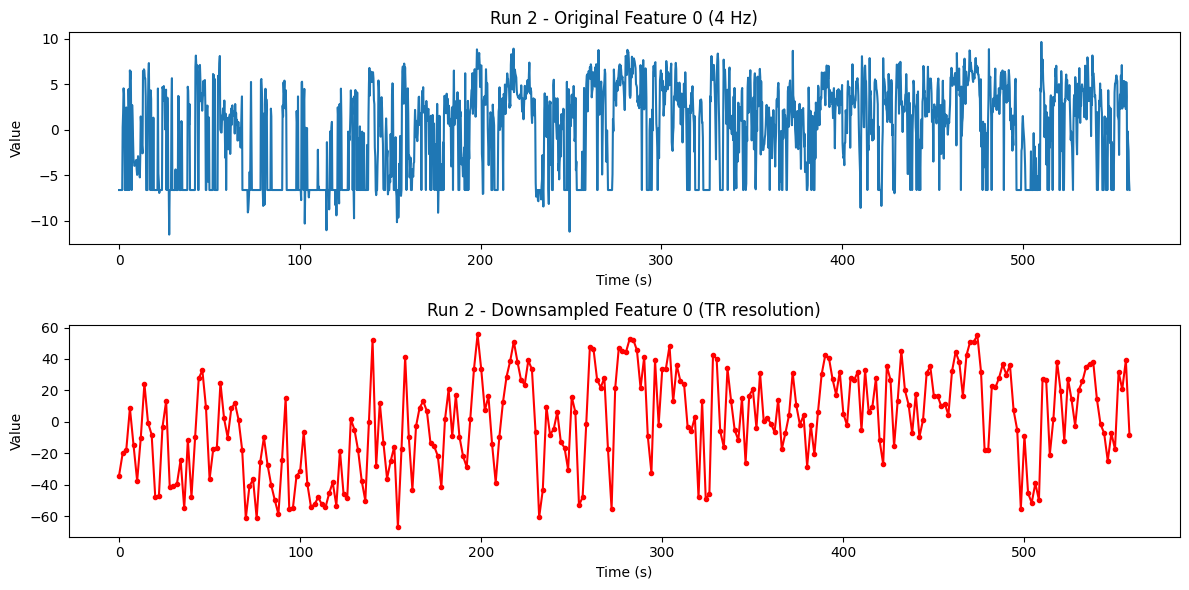

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


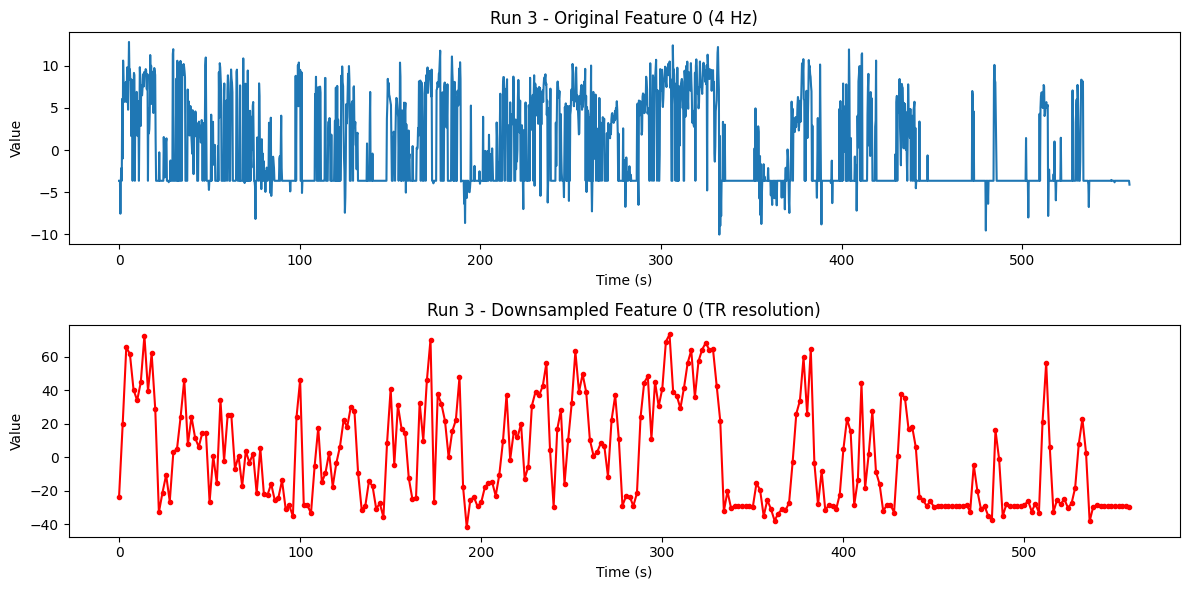

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


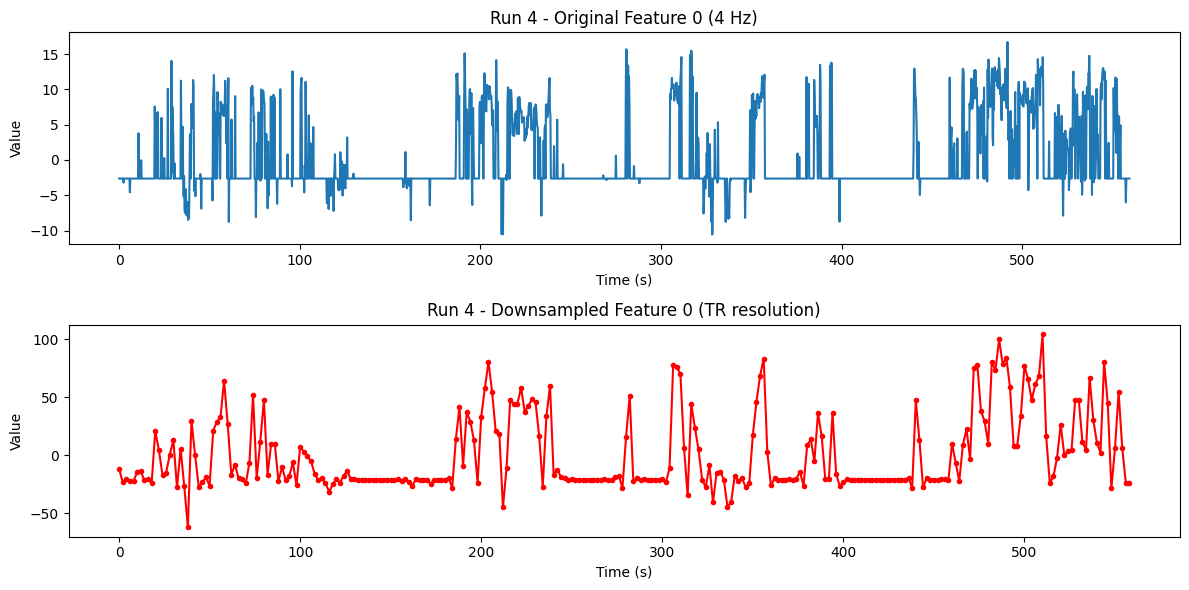

Doing lanczos interpolation with cutoff=0.500 and 3 lobes.


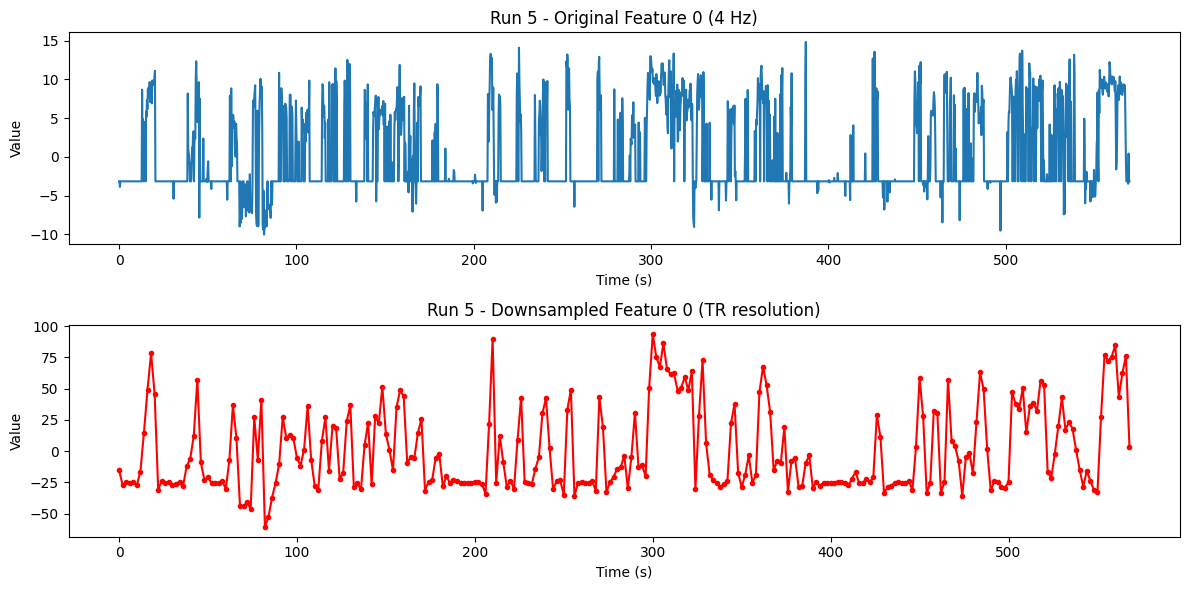

Downsampling complete!


In [19]:
# Parameters
window = 3 # Number of lobes for Lanczos kernel
cutoff_mult = 1.0

# Initialize a dictionary to store the downsampled features
downsampled_feats = {}

# Process each run
for run_number in runs_feats.keys():
    # Get the feature data for this run
    feat_data = runs_feats[run_number]

    # Get the number of TRs for this run
    num_trs = runs_fmri[run_number].shape[0]

    # Calculate the time points for the original features data
    # Assuming evenly spaced time points at annot_sampling_hz Hz
    feature_times_secs = np.arange(feat_data.shape[0]) / frame_sampling_hz

    # Calculate the time points for the new data (TRs)
    # Assuming evenly spaced time points with TR duration
    tr_times_secs = np.arange(num_trs) * TR

    # Perform Lanczos interpolation
    downsampled_data = lanczosinterp2D(
        data=feat_data,
        oldtime=feature_times_secs,
        newtime=tr_times_secs,
        window=window,
        cutoff_mult=cutoff_mult,
        rectify=False  # Set to True if you need to preserve sign
    )

    # Store the downsampled data
    downsampled_feats[run_number] = downsampled_data

    # Optionally plot the first feature dimension before and after downsampling
    if True:  # Set to True to enable plotting
        plt.figure(figsize=(12, 6))

        # Plot original data
        feature_idx_to_plot = 0
        plt.subplot(2, 1, 1)
        plt.plot(feature_times_secs, feat_data[:, feature_idx_to_plot])
        plt.title(f"Run {run_number} - Original Feature {feature_idx_to_plot} ({frame_sampling_hz} Hz)")
        plt.xlabel("Time (s)")
        plt.ylabel("Value")

        # Plot downsampled data
        plt.subplot(2, 1, 2)
        plt.plot(tr_times_secs, downsampled_data[:, feature_idx_to_plot], 'r.-')
        plt.title(f"Run {run_number} - Downsampled Feature {feature_idx_to_plot} (TR resolution)")
        plt.xlabel("Time (s)")
        plt.ylabel("Value")

        plt.tight_layout()
        plt.show()

print("Downsampling complete!")

# Now downsampled_feats contains the downsampled feature data for each run,
# with shapes matching the corresponding fMRI TR count

In [20]:
for run_number in all_run_numbers:
    # Print info about the downsampling
    print(f"Run {run_number}:")
    print(f"  Original features shape: {runs_feats[run_number].shape}")
    print(f"  Downsampled features shape: {downsampled_feats[run_number].shape}")
    print(f"  fMRI data shape: {runs_fmri[run_number].shape}")

Run 1:
  Original features shape: (2224, 21)
  Downsampled features shape: (278, 21)
  fMRI data shape: (278, 237332)
Run 2:
  Original features shape: (2237, 21)
  Downsampled features shape: (280, 21)
  fMRI data shape: (280, 237332)
Run 3:
  Original features shape: (2238, 21)
  Downsampled features shape: (280, 21)
  fMRI data shape: (280, 237332)
Run 4:
  Original features shape: (2238, 21)
  Downsampled features shape: (280, 21)
  fMRI data shape: (280, 237332)
Run 5:
  Original features shape: (2280, 21)
  Downsampled features shape: (285, 21)
  fMRI data shape: (285, 237332)


### Create delayed features for FIR
<mark>**Note:** If switching to nilearn.FirstLevelModel this is not needed. Skip this section </mark>.

In [21]:
# Delay stimuli

ndelays = 4
delays = range(1, ndelays+1) # [1,2,3,4]
print ("FIR model delays: ", delays)

fir_feats = {}
for run_number in all_run_numbers:
    fir_feats[run_number] = make_delayed(downsampled_feats[run_number], delays)

    print(f"Run {run_number}:")
    print(f"  Input features shape: {downsampled_feats[run_number].shape}")
    print(f"  FIR features shape: {fir_feats[run_number].shape}")
    print(f"  fMRI data shape: {runs_fmri[run_number].shape}")

FIR model delays:  range(1, 5)
Run 1:
  Input features shape: (278, 21)
  FIR features shape: (278, 84)
  fMRI data shape: (278, 237332)
Run 2:
  Input features shape: (280, 21)
  FIR features shape: (280, 84)
  fMRI data shape: (280, 237332)
Run 3:
  Input features shape: (280, 21)
  FIR features shape: (280, 84)
  fMRI data shape: (280, 237332)
Run 4:
  Input features shape: (280, 21)
  FIR features shape: (280, 84)
  fMRI data shape: (280, 237332)
Run 5:
  Input features shape: (285, 21)
  FIR features shape: (285, 84)
  fMRI data shape: (285, 237332)


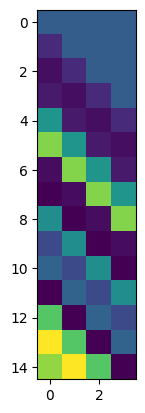

In [22]:
init_n_feats = downsampled_feats[run_number].shape[1]
plt.imshow(fir_feats['1'][:15,[0,init_n_feats, init_n_feats*2,init_n_feats*3]])

In [23]:
fir_feats[run_number].shape[1]

84

### Z-score fMRI data

In [24]:
for run_number in all_run_numbers:
    runs_fmri[run_number] = zscore(runs_fmri[run_number], axis=0)

### Train-test splitting

In [75]:

train_data = np.vstack([runs_fmri[run_number] for run_number in train_run_numbers])
test_data = np.vstack([runs_fmri[run_number] for run_number in test_run_numbers]) # only one test run but keeping this syntax for consistency

train_feats = np.vstack([fir_feats[run_number] for run_number in train_run_numbers])
test_feats = np.vstack([fir_feats[run_number] for run_number in test_run_numbers])

print('Train runs:', train_run_numbers)
print('Train data shape:', train_data.shape)
print('Train features shape:', train_feats.shape)
print('')
print('Test runs:', test_run_numbers)
print('Test data shape:', test_data.shape)
print('Test features shape:', test_feats.shape)

Train runs: ['1', '2', '4', '5']
Train data shape: (1123, 237332)
Train features shape: (1123, 84)

Test runs: ['3']
Test data shape: (280, 237332)
Test features shape: (280, 84)


### Fit Ridge regression

In [116]:
# Run regression
alphas = np.logspace(1, 3, 10) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 1 # Number of cross-validation runs.

# choosing these so that ~20% of data used to estimated alpha, 80% to estimate weights (to approx match proportions of speechmodeltutorial)
chunklen = 20
nchunks = 10

wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(train_feats, train_data, test_feats, test_data,
                                                    alphas, nboots, chunklen, nchunks,
                                                    singcutoff=1e-10, single_alpha=True) # defaults based on speechmodeltutorial

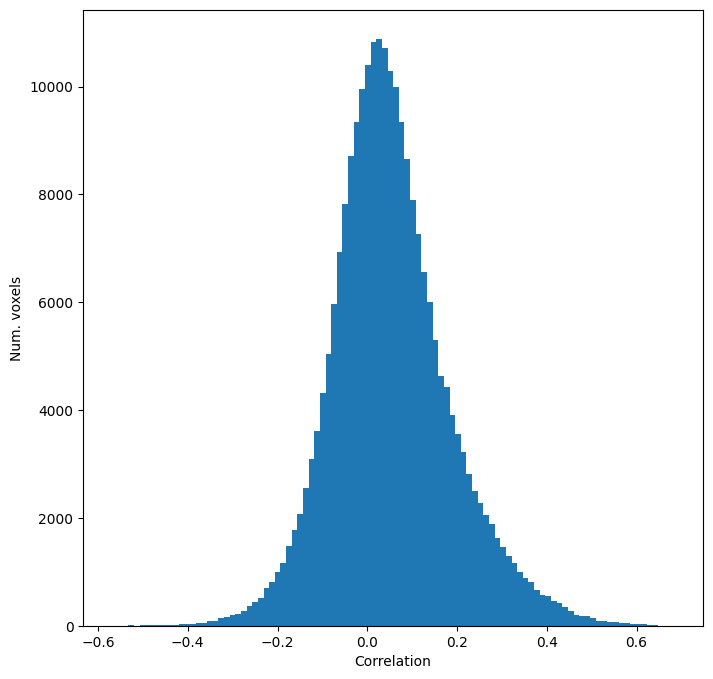

In [117]:
# Plot histogram of correlations
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(1,1,1)
ax.hist(corr, 100) # histogram correlations with 100 bins
ax.set_xlabel("Correlation")
ax.set_ylabel("Num. voxels");

**Plot accuracy (correlations) on brain**

/Users/julien/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



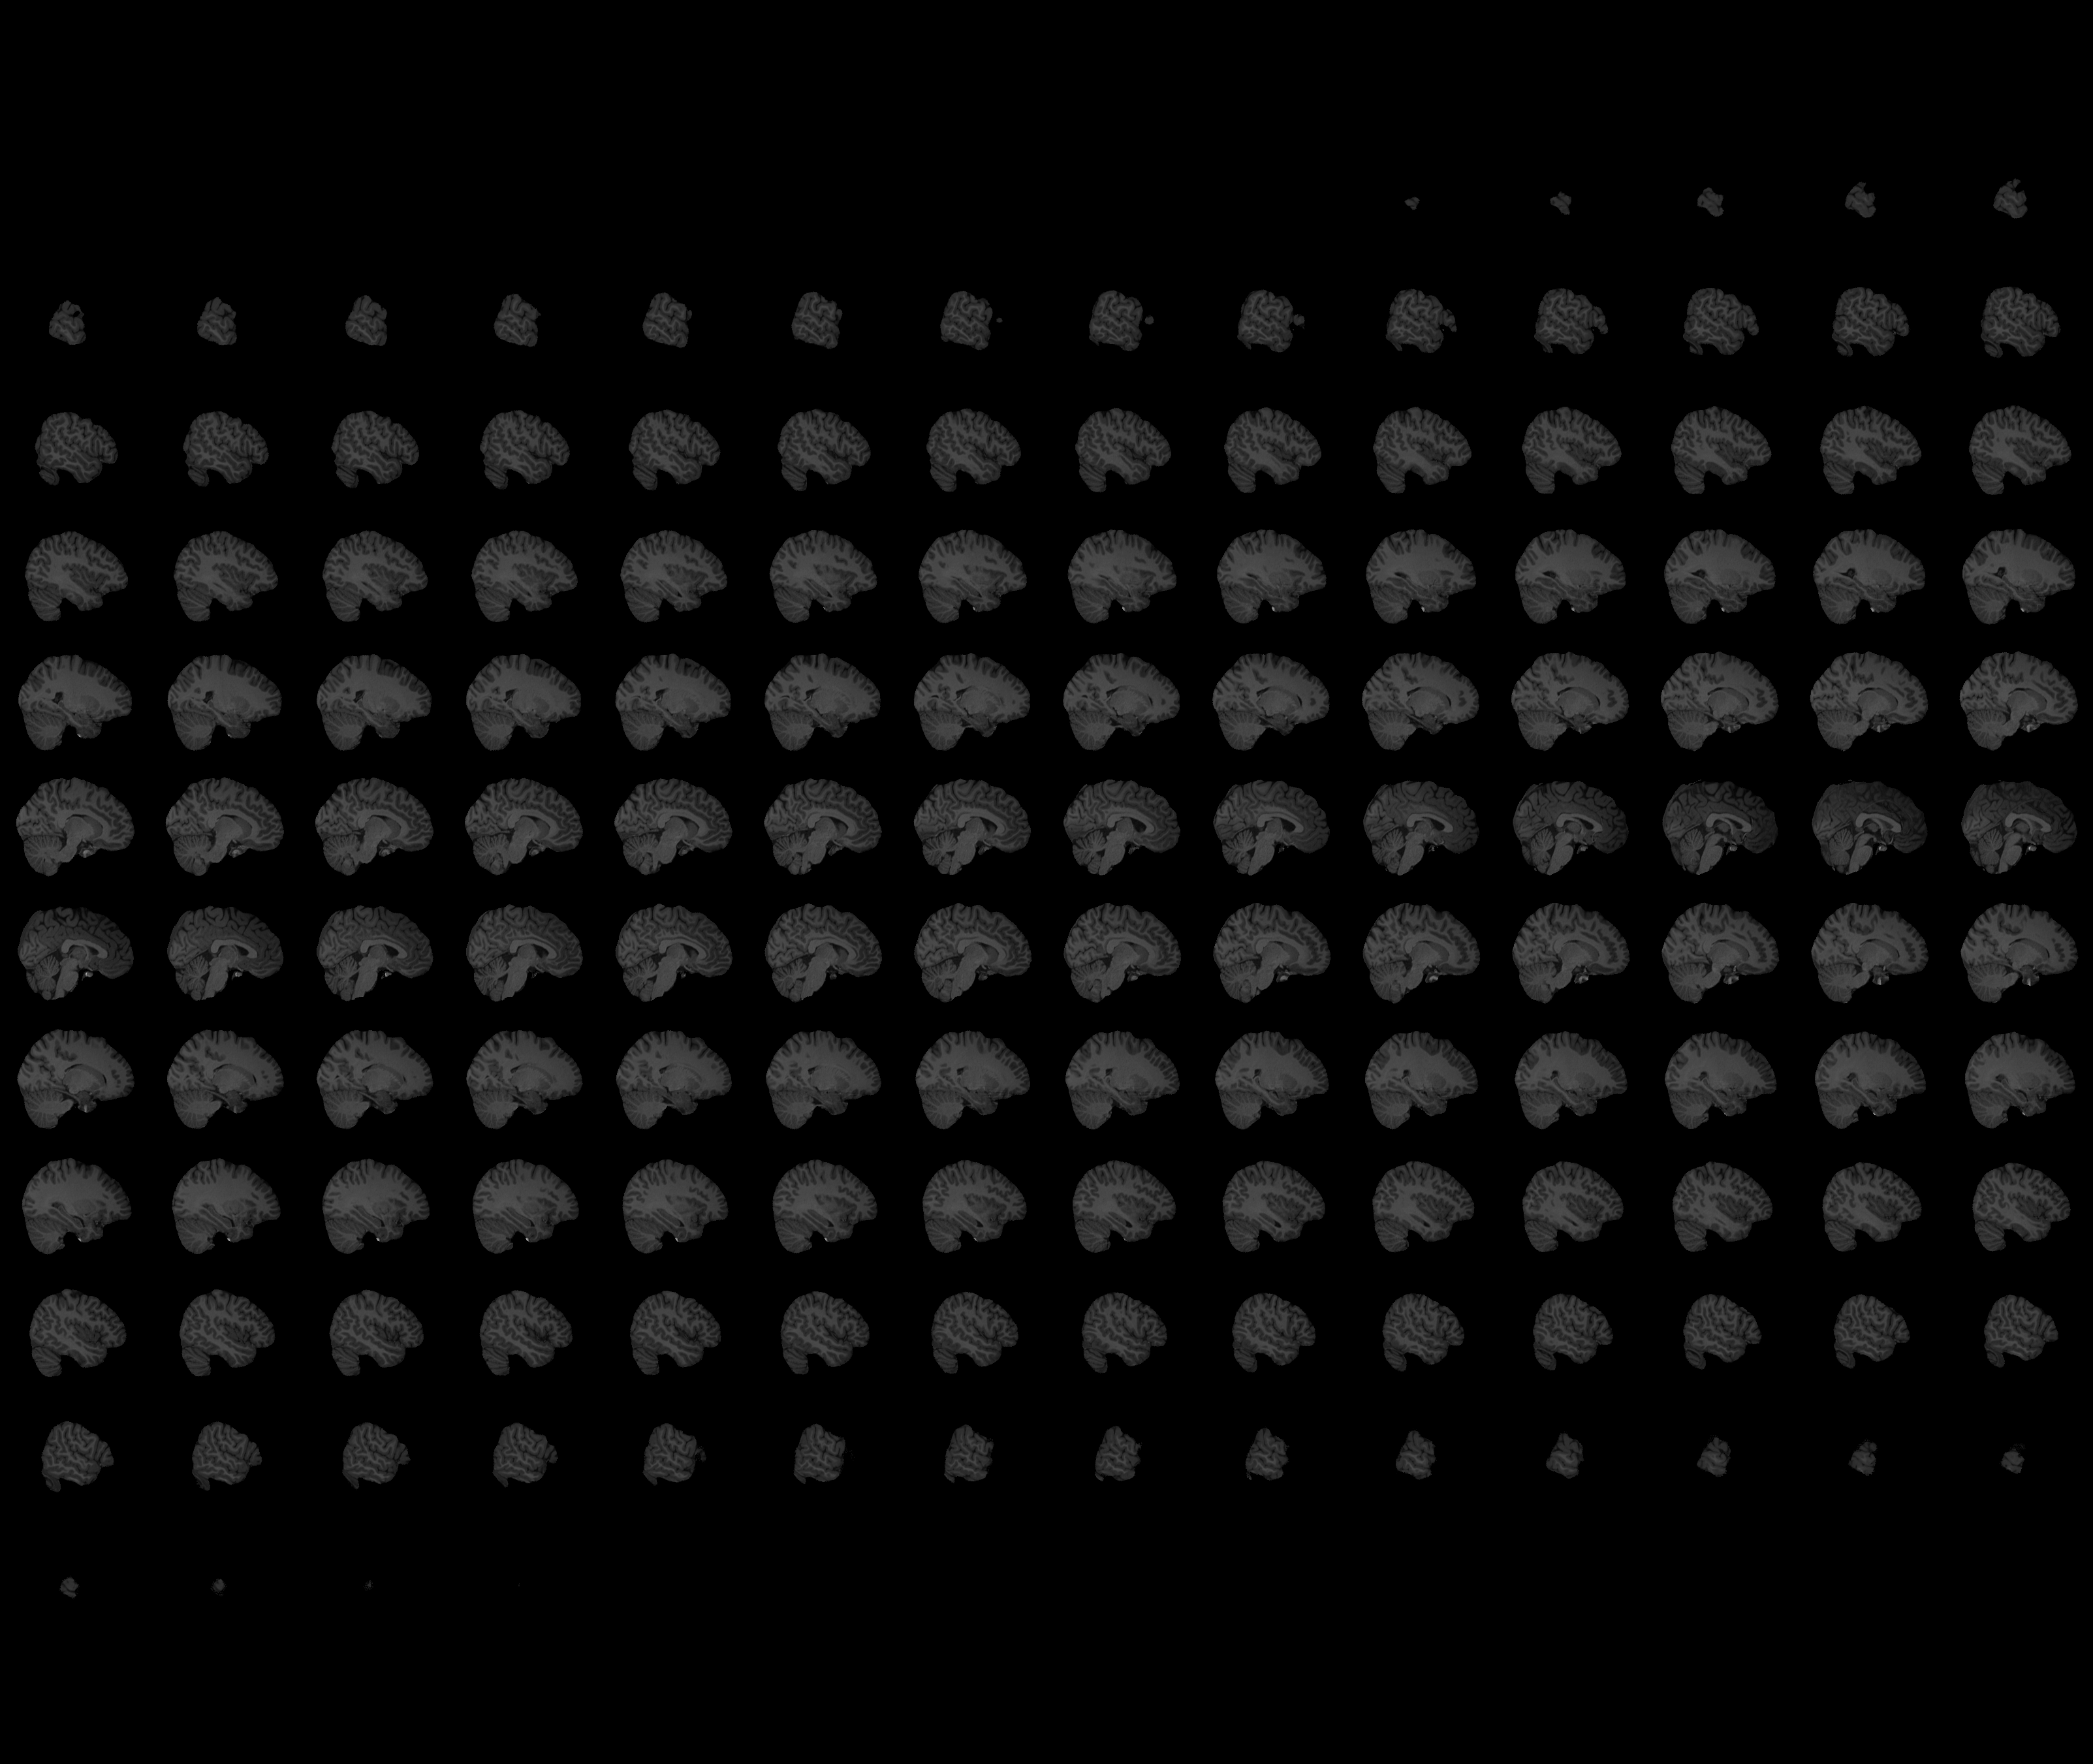
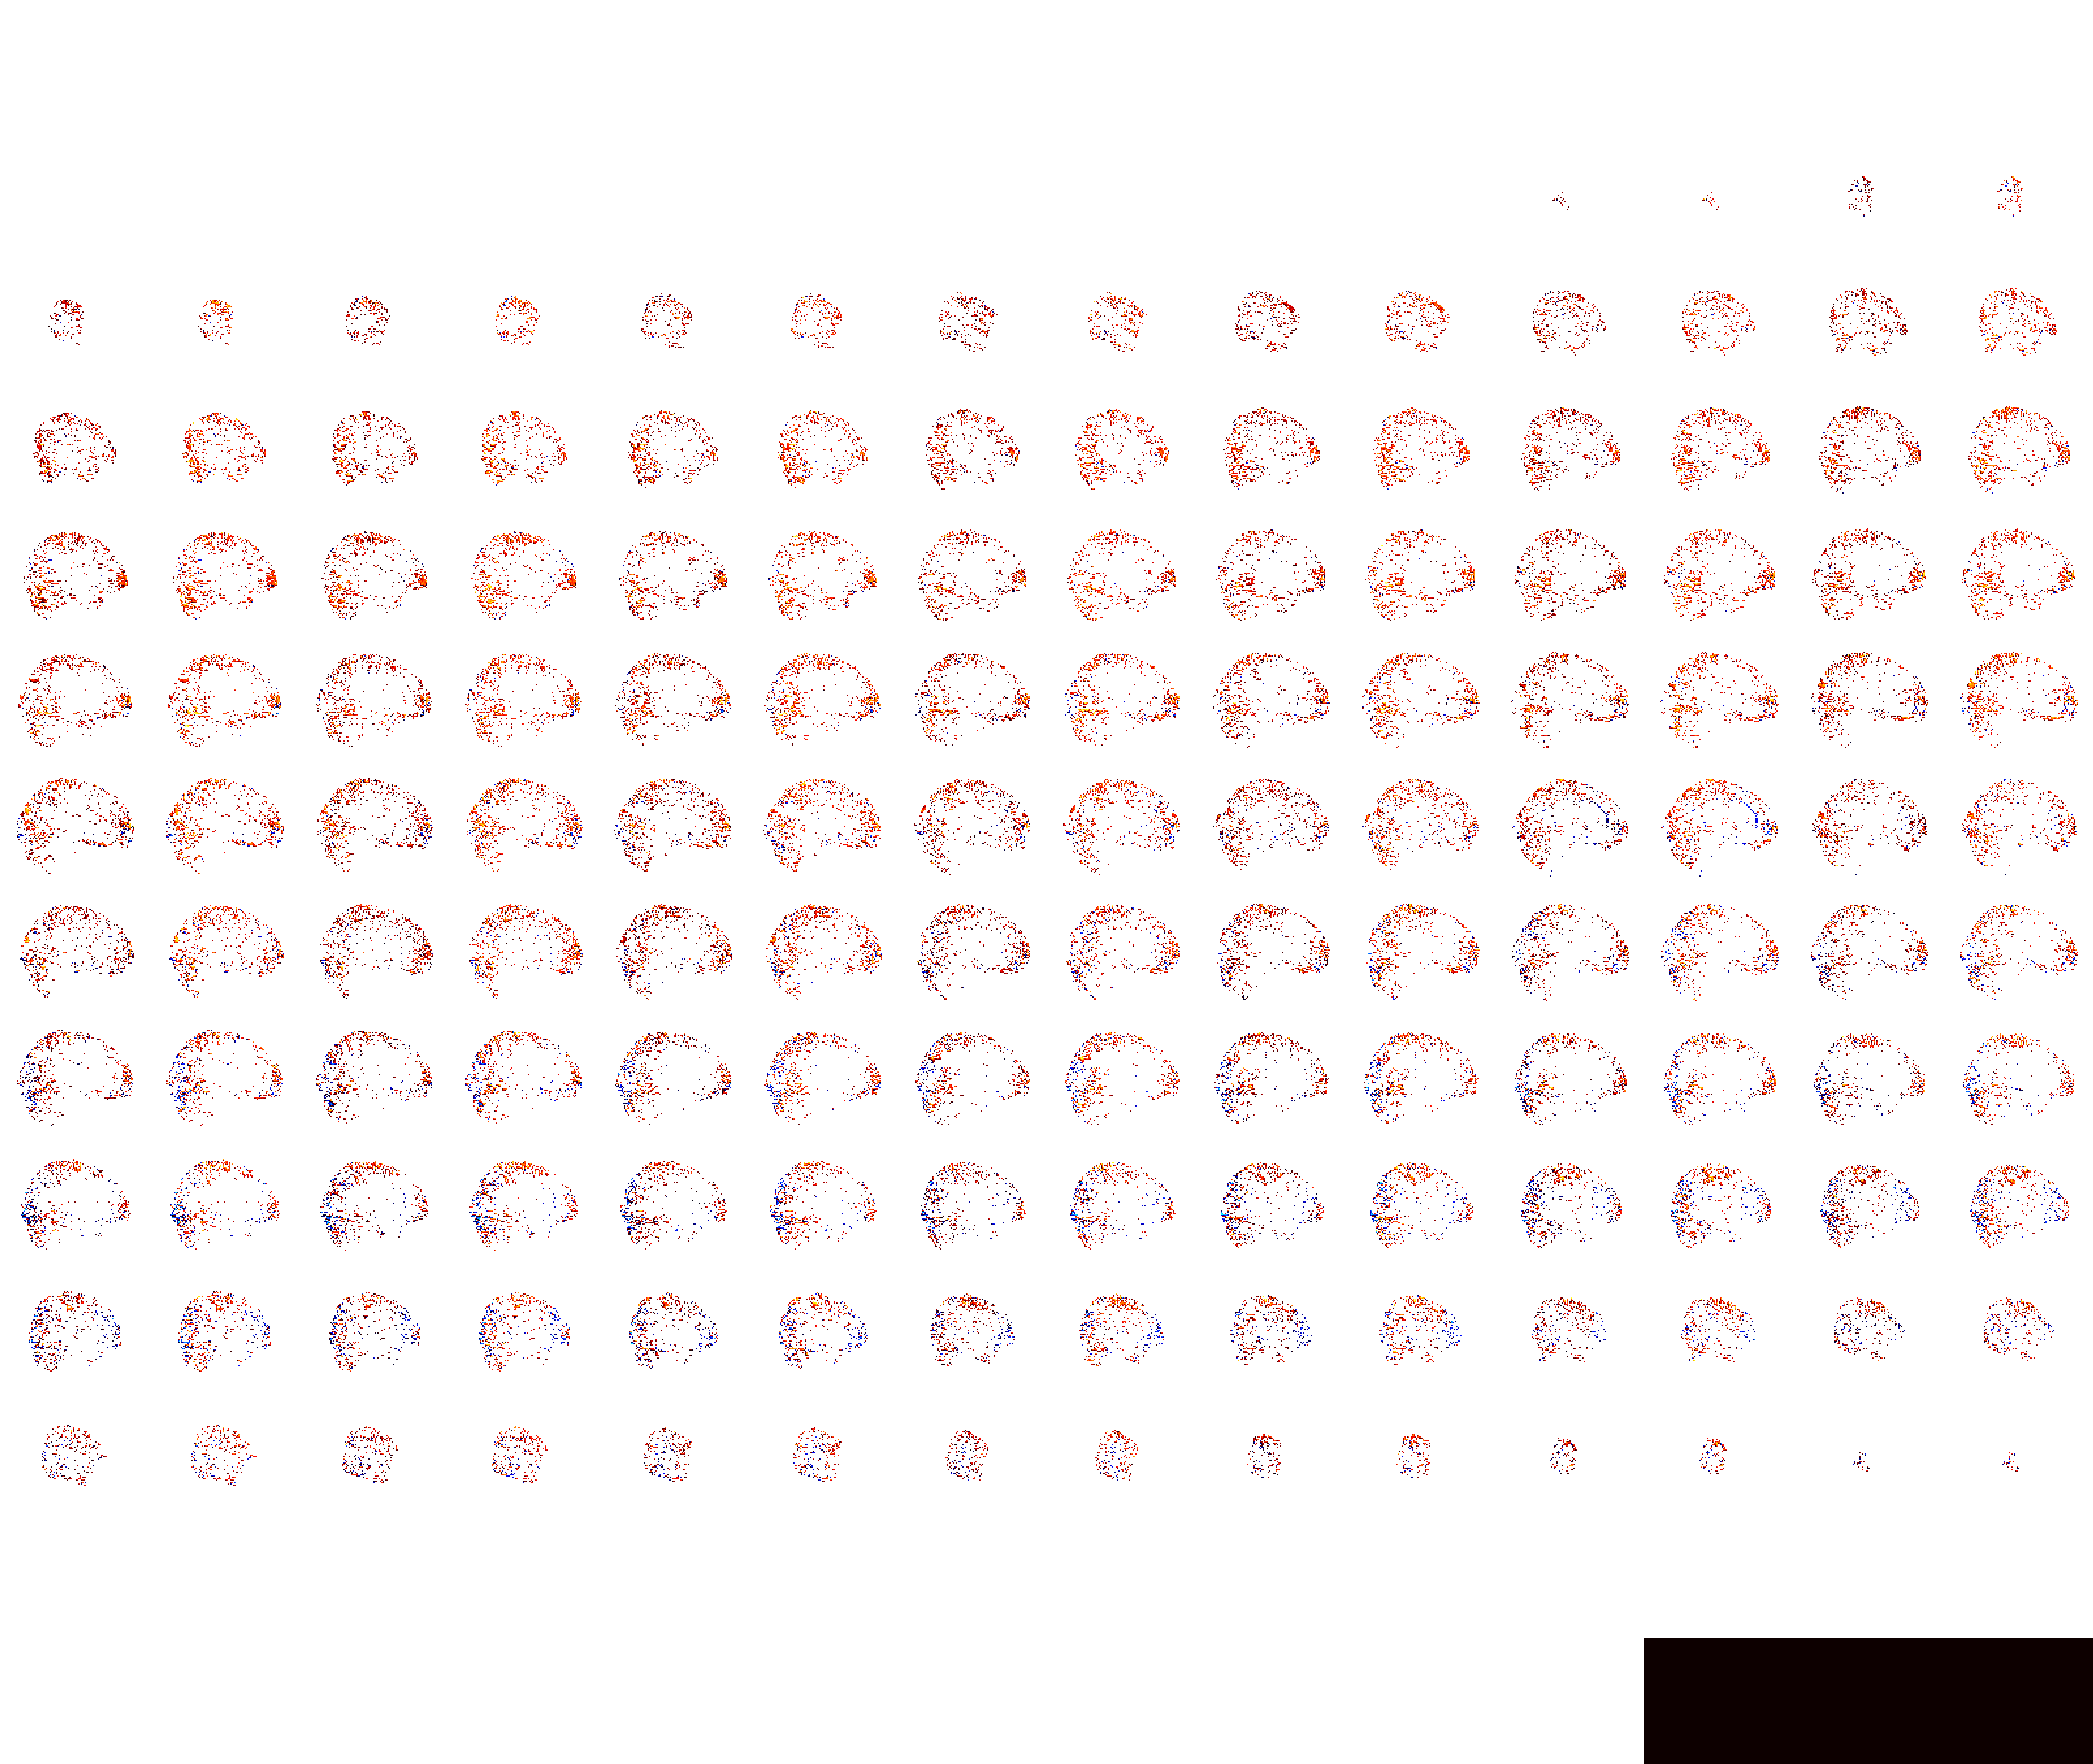

In [120]:
anat_img = image.load_img(join(fmri_dir, 'pilot2_anat_final+tlrc.nii.gz'))
# reconstruct volumetric correlation
corr_img = unmask(corr, brainmask_img)

view = view_img(corr_img, bg_img=anat_img, title='Model corrs w/ boots', threshold=0.2)
view.open_in_browser()
view

**Look at regression weights of selected feature**

In [119]:
feats_legend = np.array(feats_legend)


In [121]:
selected_feature = 'left_hand_PC_0'
idx_selected_feature =  np.where(feats_legend==selected_feature)[0]
selfeat_wt = wt[idx_selected_feature, :]
selfeat_wt_img = unmask(selfeat_wt, brainmask_img)
view = view_img(selfeat_wt_img, bg_img=anat_img, threshold=0.001)
view.open_in_browser()

/Users/julien/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


#### Look at contrasts

In [122]:
# This will look at feat1 - feat2
def calculate_contrast_feat1Minusfeat2(features):
    '''
    Contrast = feat1 - feat2
    features : list of str. length=2. example: ['hands_left_bbox_center_x', 'hands_right_bbox_center_x']
    '''
    idx_features = [np.where(feats_legend == feat)[0][0] for feat in features]
    features_weights = [wt[idx_feat, :] for idx_feat in idx_features]
    contrast = features_weights[0] - features_weights[1]

    return contrast


In [125]:
contrast_features = ['hands_left_bbox_center_x', 'hands_right_bbox_center_x']

contrast_img = unmask(contrast, brainmask_img)
view = view_img(contrast_img, bg_img=anat_img, threshold=0.001, title='leftx-rightx')
view

NameError: name 'contrast' is not defined

/Users/julien/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



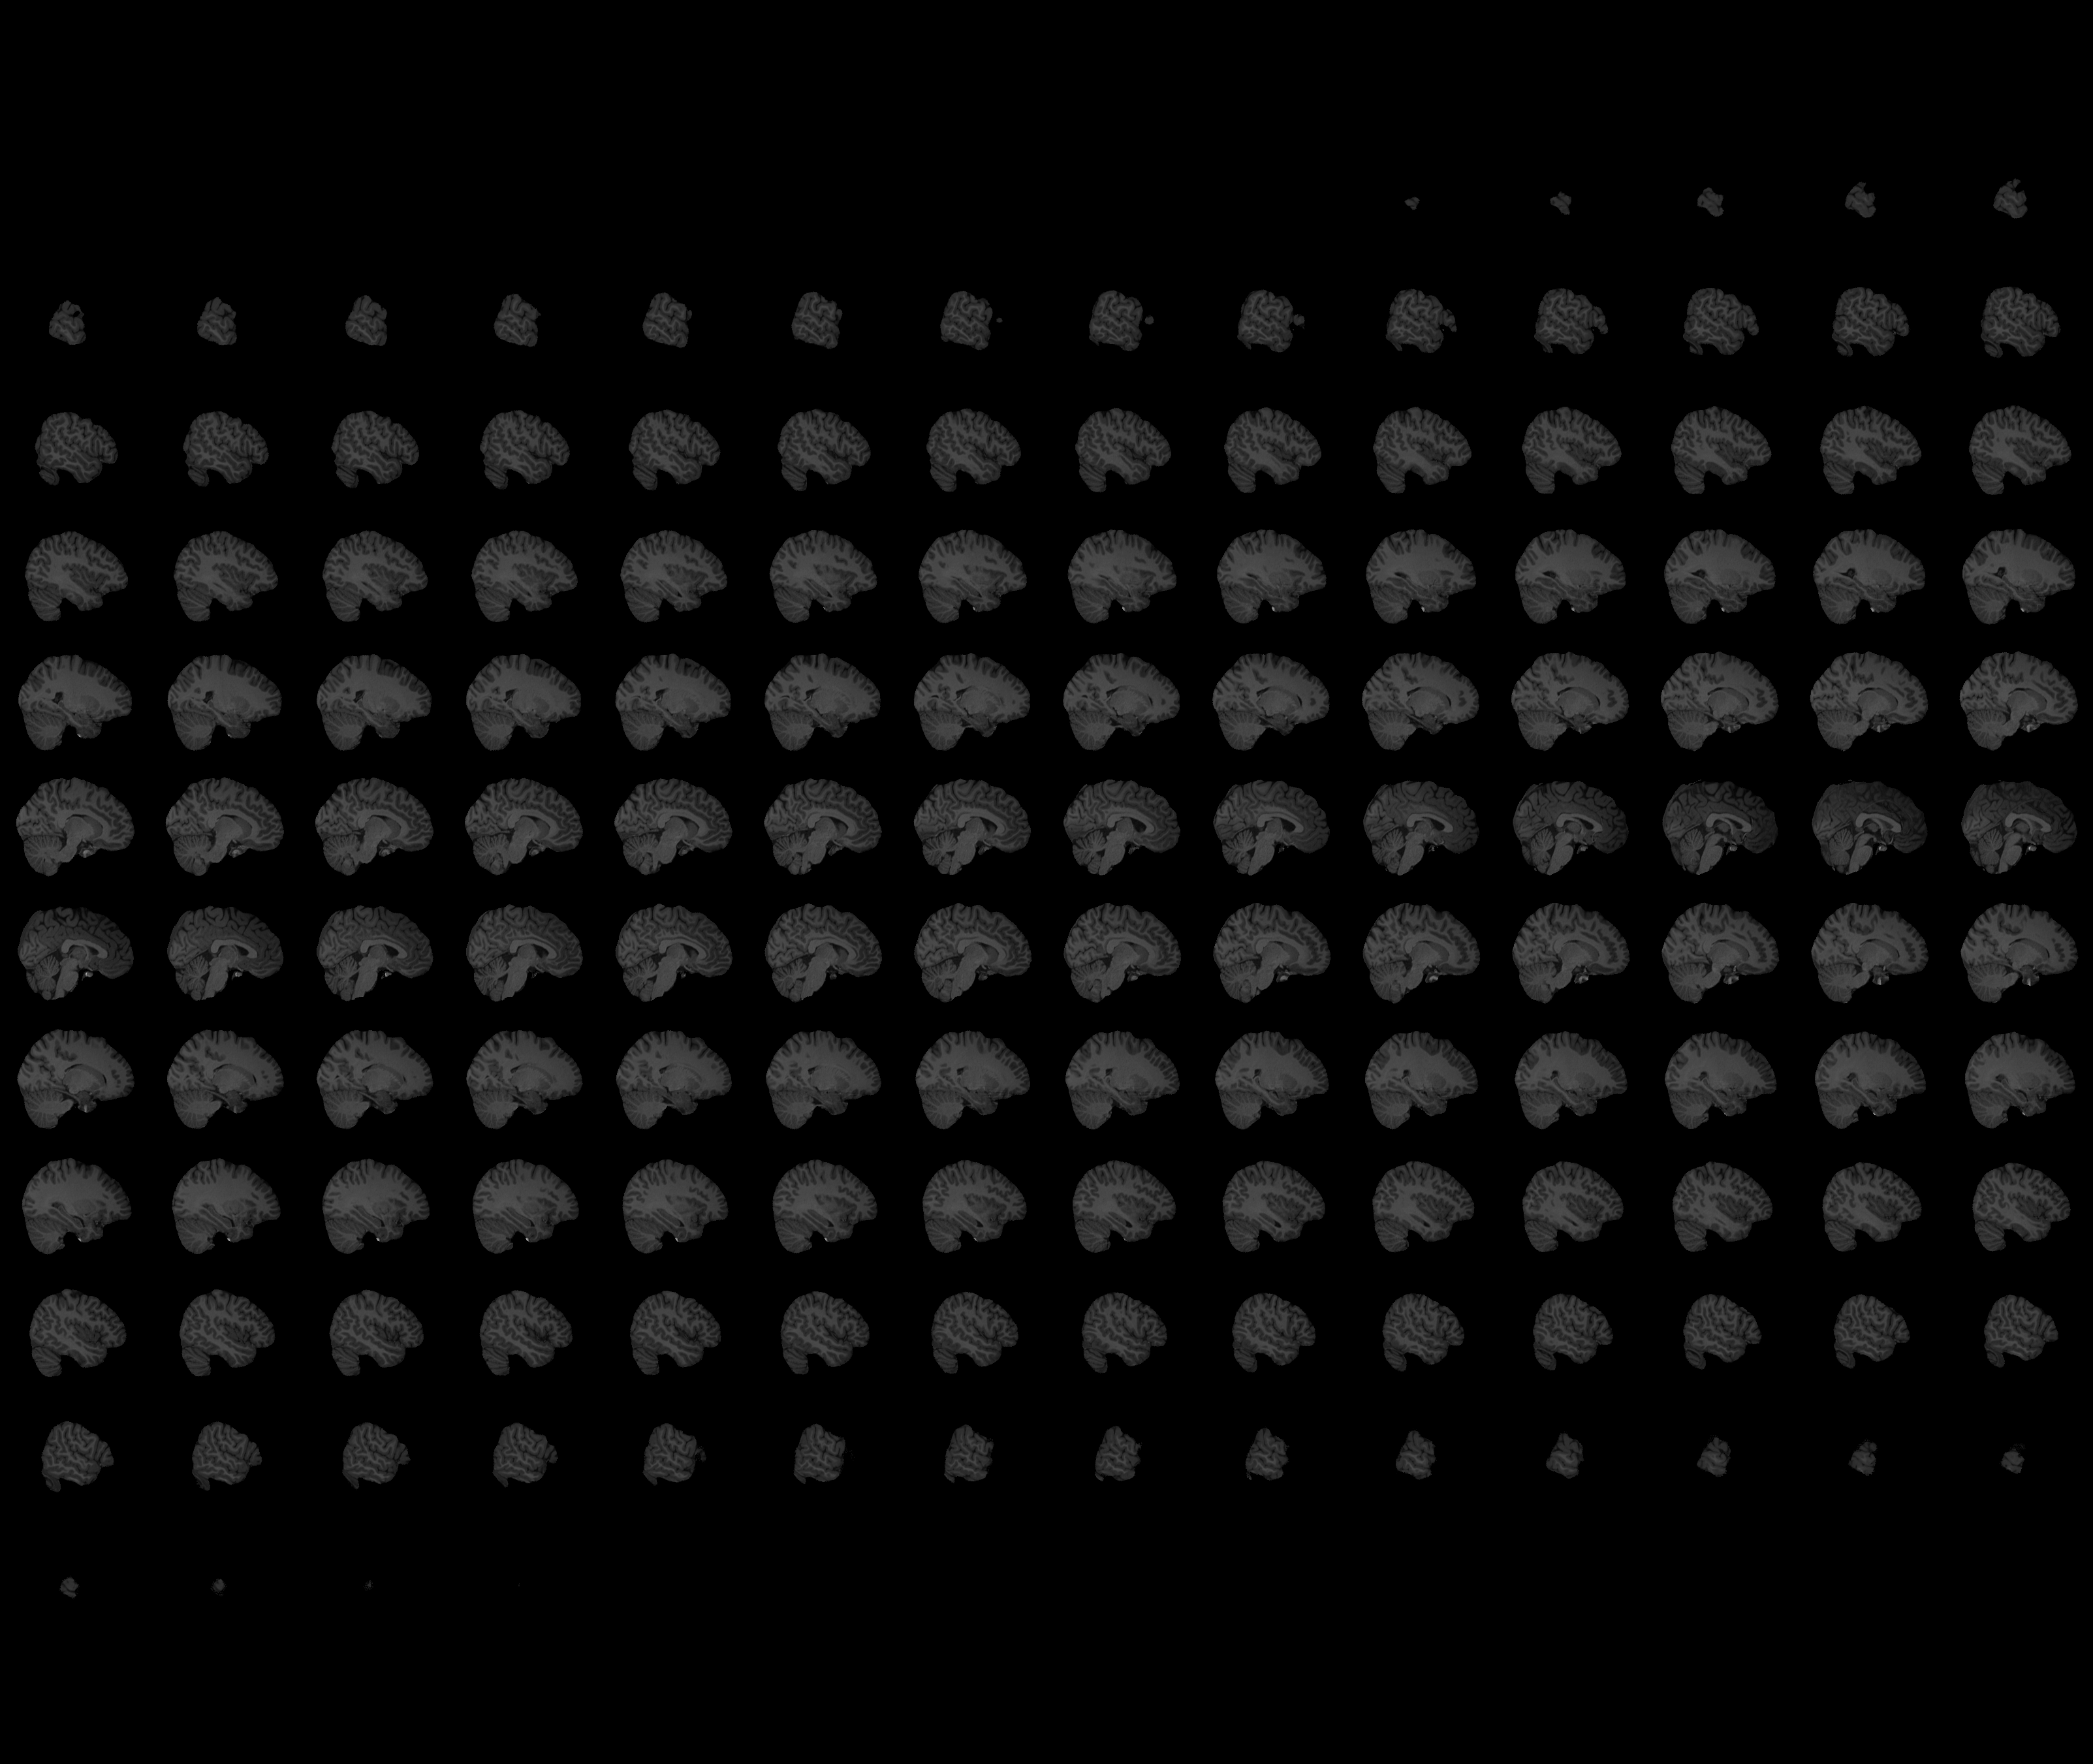
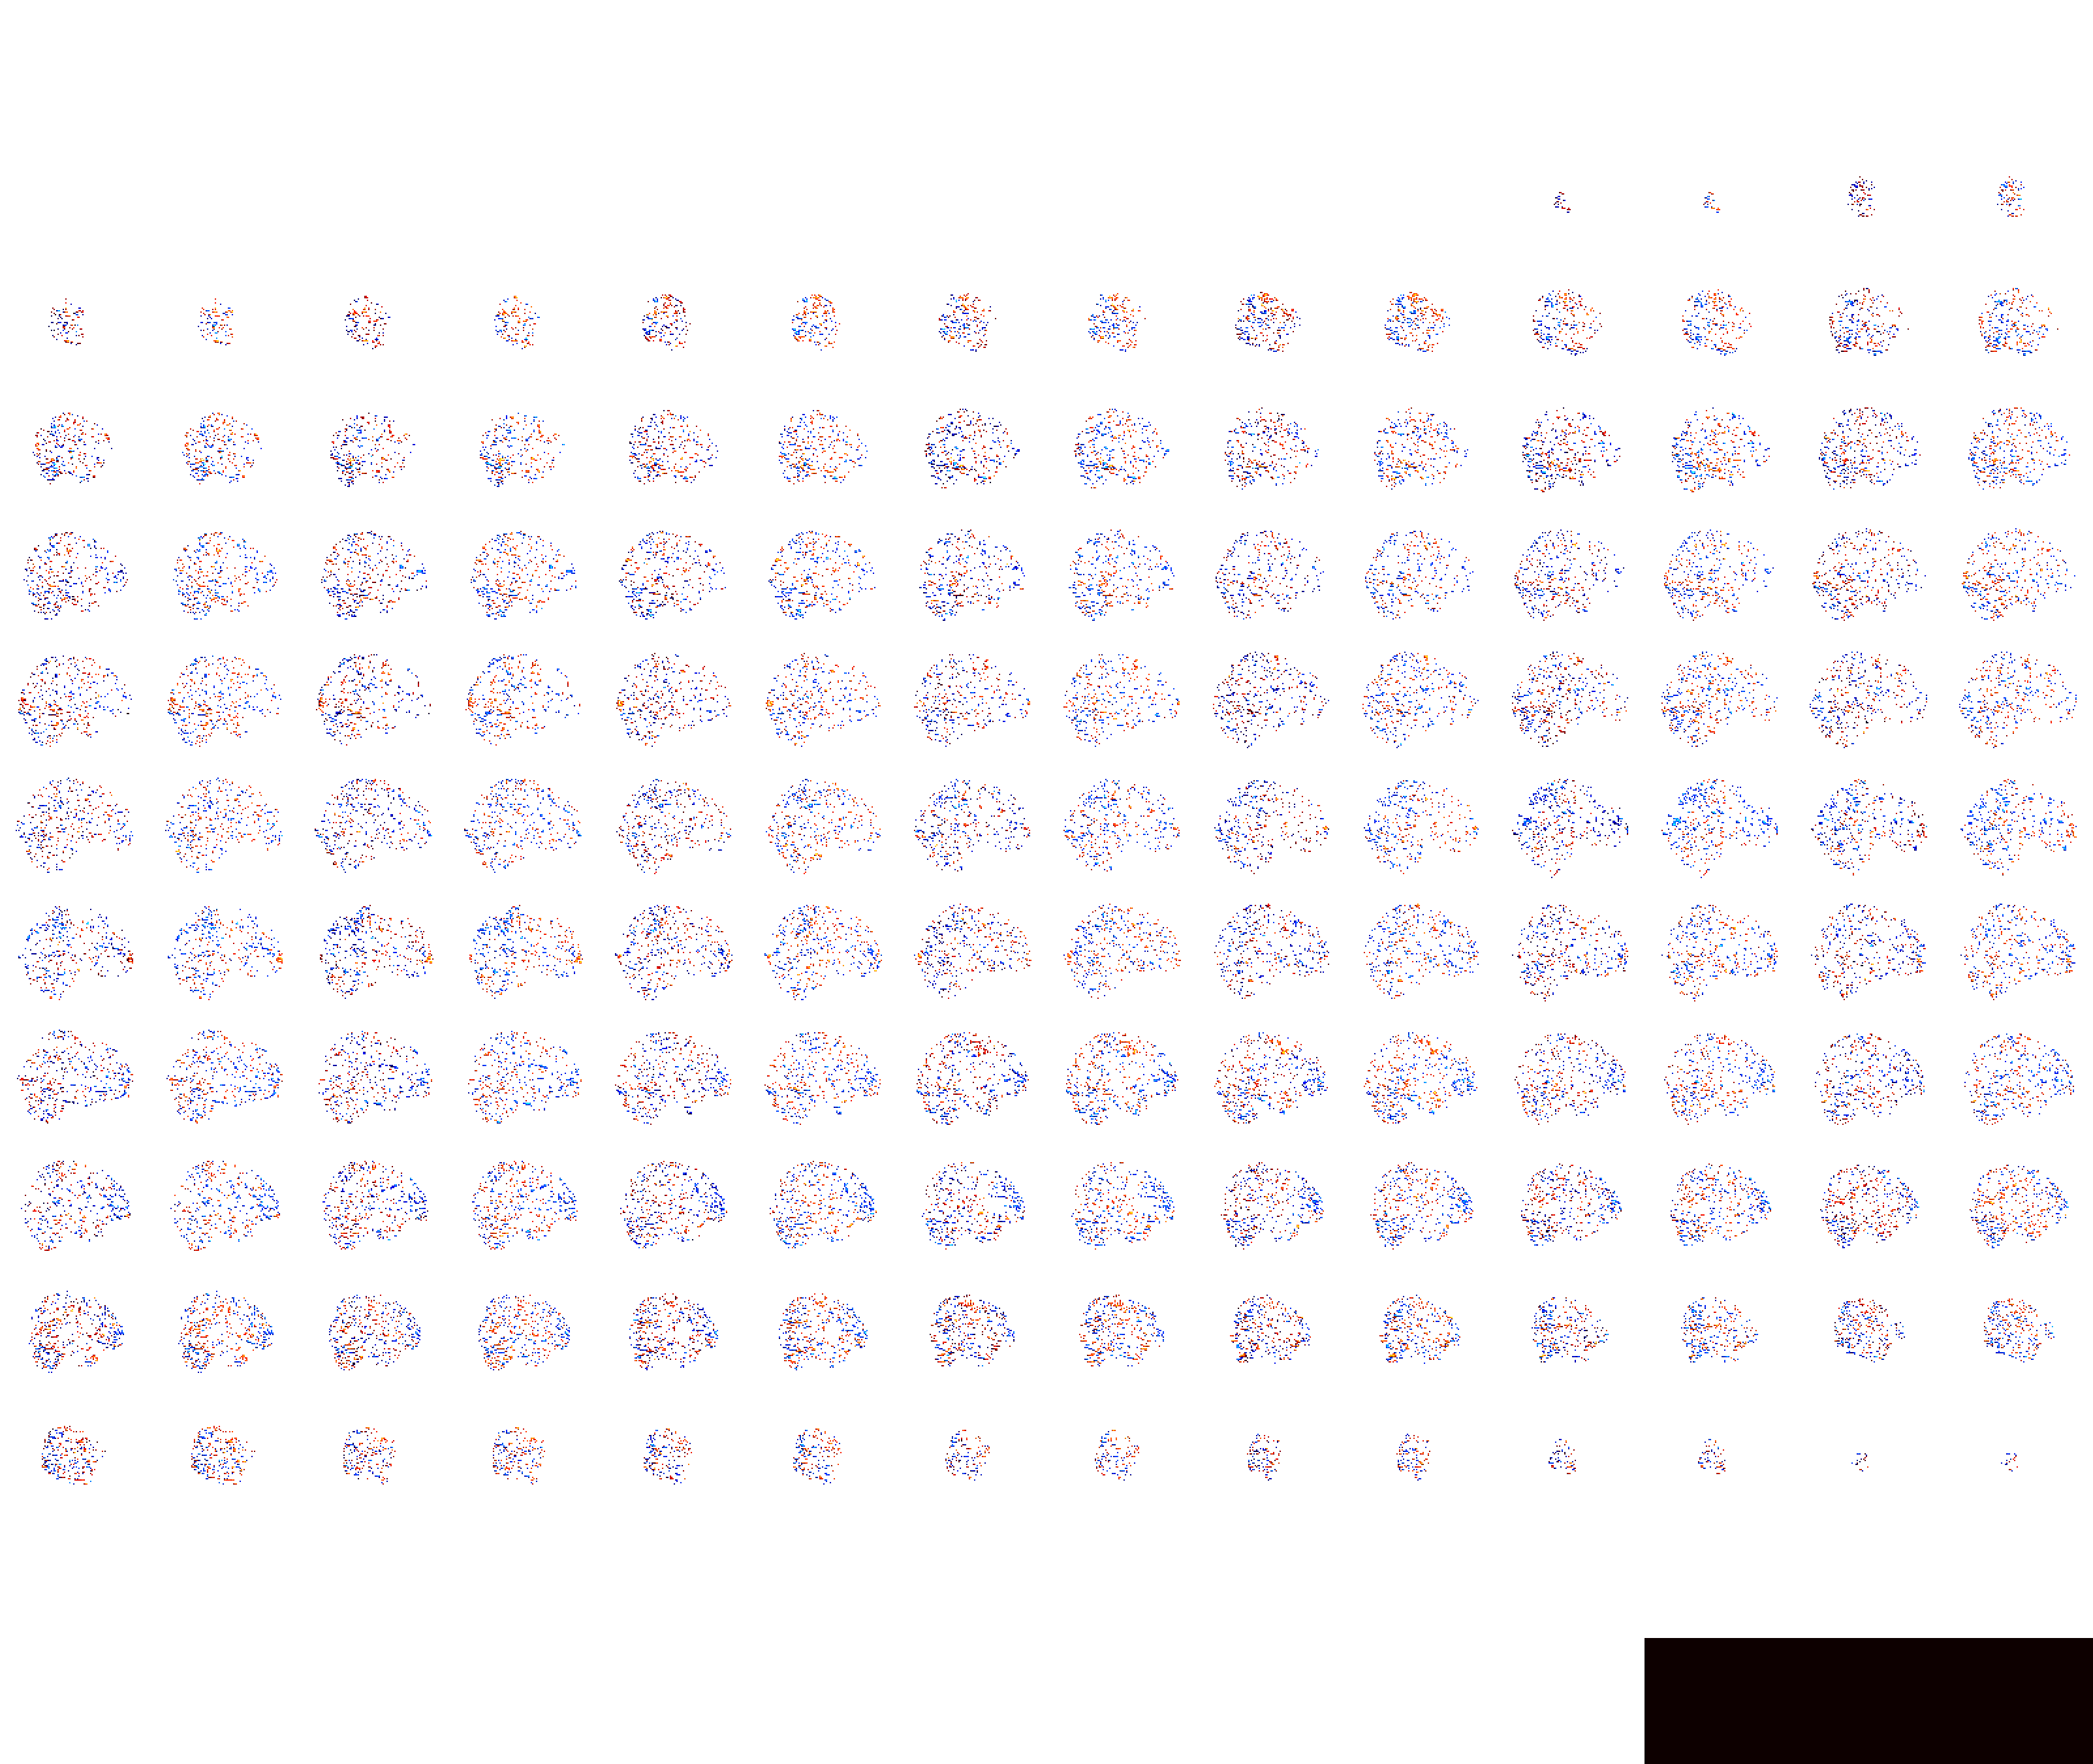

In [131]:
# plot a contrast
# ---- mean('hands_left_bbox_center_x', 'hands_left_bbox_center_y') - mean('hands_right_bbox_center_x', 'hands_right_bbox_center_y')
feat_left_hand_position = ['hands_left_bbox_center_x',
                            'hands_left_bbox_center_y']

feat_right_hand_position = ['hands_right_bbox_center_x',
                            'hands_right_bbox_center_y']


# Get indices for left hand features
idx_left_hand = []
for feat in feat_left_hand_position:
    idx = np.where(feats_legend == feat)[0][0]
    idx_left_hand.append(idx)

# Get indices for right hand features
idx_right_hand = []
for feat in feat_right_hand_position:
    idx = np.where(feats_legend == feat)[0][0]
    idx_right_hand.append(idx)

# Extract the relevant features from wt
left_hand_data = wt[idx_left_hand, :]
right_hand_data = wt[idx_right_hand, :]

# Calculate the mean across features for left and right hands
left_hand_mean = np.mean(left_hand_data, axis=0)
right_hand_mean = np.mean(right_hand_data, axis=0)

# Calculate the contrast (left - right)
contrast = left_hand_mean - right_hand_mean

contrast_img = unmask(contrast, brainmask_img)
view = view_img(contrast_img, bg_img=anat_img, threshold=0.02, title='left-right')
view.open_in_browser()
view

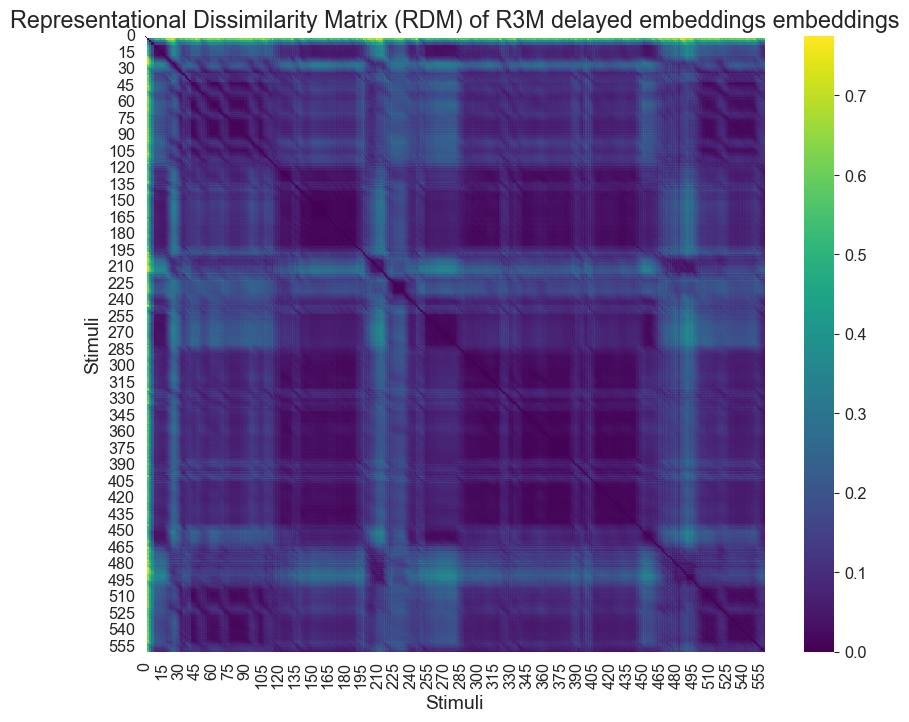

array([[0.        ,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.        ,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan, 0.        , ..., 0.52080813, 0.55861385,
        0.56862544],
       ...,
       [       nan,        nan, 0.52080813, ..., 0.        , 0.04380292,
        0.05782796],
       [       nan,        nan, 0.55861385, ..., 0.04380292, 0.        ,
        0.03098807],
       [       nan,        nan, 0.56862544, ..., 0.05782796, 0.03098807,
        0.        ]])

In [29]:
def rdm_heatmap(embeddings, model_name, plot = True, return_rdm = True,
    cmap='viridis', figsize=(10, 8), save_path=None):
    """
    Plots a dendrogram and a heatmap for the given embeddings.
    """
    # RDM for embeddings
    embedding_distances = pdist(embeddings, metric='correlation') #NOTE we don't reorder the embeddings here, and all the embeddings have same order, so we can directly compare these to do RSA
    embedding_rdm = squareform(embedding_distances)

    # embedding_rdm_df = pd.DataFrame(embedding_rdm)
    if plot:
        plt.figure(figsize=figsize)
        _ = sns.heatmap(embedding_rdm, cbar=True, cmap = cmap)
        plt.title(f"Representational Dissimilarity Matrix (RDM) of {model_name} embeddings")
        plt.xlabel("Stimuli")
        plt.ylabel("Stimuli")

        # Save or show the plot
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()
    if return_rdm:
        return embedding_rdm
rdm_heatmap(runs_R3M_delayed[4], 'R3M delayed embeddings')

## Below repeating the analysis but including movement covariates
Using ridge from HW2 instead so that we can exclude noise covariates before reconstructing the weights from all delayed FIR weights

In [25]:
sys.path.append('/Users/julien/Library/CloudStorage/Dropbox/Work/Projects/Ongoing/natcook/analyses/fMRI/utils/HW2')
from ridge_tools import cross_val_ridge
from ridge_tools import corr as correlate ## can use this function to compute pearson correlation for each column

sys.path.append('/Users/julien/Library/CloudStorage/Dropbox/Work/Projects/Ongoing/natcook/analyses/fMRI/utils')
from func import average_feature_weights_over_delays

### Include movement covariates
These matrices were estimated at preproc. The time dimension will match the TRs so no need to do any sampling fixes


<mark> Movement covariates are not convolved with HRF/FIR, they are added as is </mark>

**Note:** eventually can add scanner drift params

In [26]:
# ---- Read movement matrices
runs_movement = {}
for run_number in ['1','2','3','4','5','6']: # hard coding this here, need to bring back the run 6
    movement_path = join(fmri_dir, f'pilot2_natcook_movement_run{run_number}.1D')
    runs_movement[run_number] = np.loadtxt(movement_path)
    print('run', run_number, 'shape:', runs_movement[run_number].shape)


# ----- Average over test runs
test_run_movement = np.mean([runs_movement['3'], runs_movement['6']], axis=0)
assert test_run_movement.shape == runs_movement['3'].shape
runs_movement['3'] = test_run_movement
del runs_movement['6']


# ---- Drop the TRs with fixation cross, using vars calculate previously when we did this for the fmri runs
for run_number in all_run_numbers:
    runs_movement[run_number] = runs_movement[run_number][nTRs_drop_from_start:-nTRs_drop_from_end, :] # Drop TRs from start and end of the run

    assert runs_movement[run_number].shape[0] == runs_fmri[run_number].shape[0]

run 1 shape: (296, 6)
run 2 shape: (298, 6)
run 3 shape: (298, 6)
run 4 shape: (298, 6)
run 5 shape: (303, 6)
run 6 shape: (298, 6)


**Add movement features to runs_feats** <br>
and update feats_legend accordingly

In [27]:
# update the feats_legend list
num_movement_feats = runs_movement['1'].shape[1] # this will be used again later to reconstruct weights averaged over FIR delays
movement_feat_legends = [f'covariate_movement_{i}' for i in range(num_movement_feats)]
feats_legend = np.append(feats_legend, movement_feat_legends)


# Movement covariates are added "as is" without FIR or convolution
for run_number in all_run_numbers:
    fir_feats[run_number] = np.hstack([fir_feats[run_number], runs_movement[run_number]])

print('fir_feats shape:', fir_feats['1'].shape, '\ndim1 has shape n_fir_feats (=n_feats*n_delays) + num_movement_feats')

fir_feats shape: (278, 90) 
dim1 has shape n_fir_feats (=n_feats*n_delays) + num_movement_feats


In [28]:
# assuming fmri is already z-scored


In [29]:
# train-test splitting
train_data = np.vstack([runs_fmri[run_number] for run_number in train_run_numbers])
test_data = np.vstack([runs_fmri[run_number] for run_number in test_run_numbers]) # only one test run but keeping this syntax for consistency

train_feats = np.vstack([fir_feats[run_number] for run_number in train_run_numbers])
test_feats = np.vstack([fir_feats[run_number] for run_number in test_run_numbers])

print('Train runs:', train_run_numbers)
print('Train data shape:', train_data.shape)
print('Train features shape:', train_feats.shape)
print('')
print('Test runs:', test_run_numbers)
print('Test data shape:', test_data.shape)
print('Test features shape:', test_feats.shape)


Train runs: ['1', '2', '4', '5']
Train data shape: (1123, 237332)
Train features shape: (1123, 90)

Test runs: ['3']
Test data shape: (280, 237332)
Test features shape: (280, 90)


In [30]:
def ridge_wrapper(train_feats, train_data, test_feats, test_data):

    weights, lambdas = cross_val_ridge(train_feats, train_data, n_splits=4,
                                                lambdas=np.array([10**i for i in range(-6, 10)]), method="ridge_sk")
    test_accuracy = correlate(test_data, np.dot(test_feats, weights)) # correlation between real data and predictions

    return weights, lambdas, test_accuracy

In [31]:
res_with_movement = ridge_wrapper(train_feats,
                                  train_data,
                                  test_feats,
                                  test_data)

fold 0 of 4, time taken: 25.263023138046265
fold 1 of 4, time taken: 24.27153706550598
fold 2 of 4, time taken: 23.19410991668701
fold 3 of 4, time taken: 25.40743589401245


In [94]:
res_no_movement = ridge_wrapper(train_feats[:,:-num_movement_feats],
                                train_data,
                                test_feats[:,:-num_movement_feats],
                                test_data)

fold 0 of 4, time taken: 15.424477338790894
fold 1 of 4, time taken: 15.568044185638428
fold 2 of 4, time taken: 15.802589178085327
fold 3 of 4, time taken: 15.842060089111328


In [114]:
# plot accuracy WITH MOVEMENT
accuracy_with_movement_img = unmask(res_with_movement[2], brainmask_img)
view = view_img(accuracy_with_movement_img, bg_img=anat_img, threshold=0.2, title='with movt')
view.open_in_browser()

/Users/julien/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [115]:
# plot accuracy WITHOUT MOVEMENT
accuracy_no_movement_img = unmask(res_no_movement[2], brainmask_img)
view = view_img(accuracy_no_movement_img, bg_img=anat_img, threshold=0.2, title='no movt')
view.open_in_browser()


/Users/julien/miniforge3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


#### To reconstruct weights

In [108]:
# If no covariates to exclude, straightforward
init_num_feats = runs_feats['1'].shape[1] # this excludes noise covariates here
weights_no_movement = average_feature_weights_over_delays(res_no_movement[0], n_feats=init_num_feats)
print(weights_no_movement.shape)


(21, 237332)


In [109]:
res_with_movement[0].shape

(90, 237332)

In [113]:
# Since the movement covariates were not delayed, we need to exclude them first
weights_with_movement_main_vars_only = res_with_movement[0][:-num_movement_feats,:]
covariates_weights = res_with_movement[0][-num_movement_feats:,:]


weights_with_movement = average_feature_weights_over_delays(weights_with_movement_main_vars_only,
                                                             n_feats=init_num_feats)
print(covariates_weights.shape)
print(weights_with_movement.shape)

(6, 237332)
(21, 237332)
